# Prediction model: Solar radiation
In this notebook, different ML algorithms will be trained to develop the prediction model of hourly solar radiation on horizontal plane with the datasets obtained from:


**Radiation from the day before the call** https://opendata.aemet.es/centrodedescargas/productosAEMET<br>
**Solar radiation of two days before the day of data collection** http://www.soda-pro.com/web-services/radiation/cams-radiation-service<br>
**Climate data for the five days prior to the call** https://openweathermap.org/api/one-call-api#history<br>
**Weather forecast for the two days after the call** https://openweathermap.org/api/one-call-api<br>

- [Preparation](#Preparation)<br>

### 1. [The data to be used to train and validate the model is imported](#The-data-to-be-used-to-train-and-validate-the-model-is-imported)

### 2. [The data is divided into train and test](#The-data-is-divided-into-train-and-test)

### 3. [Base model](#Base-model)

### 4. [Linear regression](#Linear-regression)

### 5. [k-Nearest Neighbors](#k-Nearest-Neighbors)

### 6. [Decision tree](#Decision-tree)

### 7. [Polynomial regression](#Polynomial-regression)

### 8. [Gradient boosting](#Gradient-boosting)

### 9. [Random forest](#Random-forest)

### 10. [GridSearchCV](#GridSearchCV)

### 11. [Linear regression with GridSearchCV](#Linear-Regression-with-GridSearchCV)

### 12. [k-Nearest Neighbors with GridSearchCV](#k-Nearest-Neighbors-with-GridSearchCV)

### 13. [Decision tree with GridSearchCV](#Decision-tree-with-GridSearchCV)

### 14. [Gradient boosting with GridSearchCV](#Gradient-boosting-with-GridSearchCV)

### 15. [Random forest with Regressor RandomizedSearchCV](#Random-forest-with-Regressor-RandomizedSearchCV)

### 16. [Tensorflow](#Tensorflow)

### 17. [Model selection](#Model-selection)

### 18. [Check for overfitting](#Check-for-overfitting)

### 19. [The model is saved](#The-model-is-saved)


## Previous note
In order to run the script properly, use the following command line to open the notebook from the terminal:

In [1]:
#jupyter-lab --NotebookApp.iopub_data_rate_limit=1.0e15

**CAUTION:** It takes hours to run

## Preparation

The working directory is set

In [2]:
%cd /home/dsc/git/TFM/

/home/dsc/git/TFM


In [3]:
directorio = '/home/dsc/git/TFM/'

The necessary libraries are imported

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

### ``dividir_train_test()``
This function divides the data into train and test sets:
- Train: prop (Default: 80%)
- Test: 100% - prop

In [5]:
def dividir_train_test(x,y, prop = 0.8):
    
    # TRain ratio
    tam_train = prop

    # It is divided into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = tam_train, random_state = 1)

    print('x_train: {}%. Nº of data: {}'.format((len(x_train)/len(x))*100, len(x_train)))
    print('y_train: {}%. Nº of data: {}'.format((len(y_train)/len(y))*100, len(y_train)))


    print('x_test: {}%. Nº of data: {}'.format((len(x_test)/len(x))*100, len(x_test)))
    print('y_test: {}%. Nº of data: {}'.format((len(y_test)/len(y))*100, len(y_test)))
    
    return x_train, x_test, y_train, y_test

### ``graf_compara()``

This function represents the actual versus predicted values using vertical bars

In [6]:
def graf_compara(nombre_modelo, y_real, y_pred):
    
    # Prediction values
    predic = pd.DataFrame({'Dato': y_pred})
    predic.insert(len(predic.columns),"index",[i for i in range(0,len(predic["Dato"]))],True)
    
    # Real values
    real = pd.DataFrame({'Dato': y_real})
    real.insert(len(real.columns),"index",[i for i in range(0,len(real["Dato"]))],True)
    
    # Comparison
    comparacion = pd.concat([real, predic], keys=["Real", "Prediccion"]).reset_index()
    comparacion.drop(['level_1'], axis=1, inplace = True)
    comparacion.columns = ['Tipo', 'Dato', "Index"]
    #print(comparacion)

    sns.catplot(data = comparacion, kind = "bar", x = "Index", y = "Dato", hue = "Tipo", estimator = np.median, height = 10, aspect = 5)

### ``mape_fun()``

In [7]:
def mape_fun(y_real, y_pred): 
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    return np.mean(np.abs((y_real - y_pred) / y_real)) * 100

### ``metricas()``

This function calculates the different metrics of the prediction produced by the model

Metrics: ``mae``, ``mse``,``rmse``, ``r2``, ``mape``

In [8]:
def metricas(modelo, y_real, y_pred):
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # MAE: the error is calculated as an average of absolute differences between the target values and the predictions. All individual differences are weighted equally in the average
    mae = mean_absolute_error(y_real, y_pred)

    # MSE: measures the mean squared error of the predictions. For each point, calculates the squared difference between the predictions and the target and then average those values
    mse = mean_squared_error(y_real, y_pred, squared = False)
    
    # RMSE: is the square root of MSE. It has the scale of the target variable
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    
    # R^2: it is closely related to the MSE, but has the advantage of being scale-free. It is always between -∞ and 1
    r2 = r2_score(y_real, y_pred)
    
    # MAPE: For each object, the absolute error is divided by the target value, giving a relative error
    #mape = mape_fun(y_real, y_pred)
    
    
    print('MODEL: ', modelo)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('R2 : ', r2)
    #print('MAPE : ', mape)
    
    #return modelo, mae, mse, rmse, r2, mape
    return modelo, mae, mse, rmse, r2

### ``compracion_metricas()``

This function represents the metrics of each trained model, so that they can be compared

In [9]:
def compracion_metricas(lista_modelos):
    
    plt.style.use('ggplot')
    
    # The dataframes are created to host the metrics
    df_mae = pd.DataFrame(columns = ['mae', "modelo"])
    df_mse = pd.DataFrame(columns = ['mse', "modelo"])
    df_rmse = pd.DataFrame(columns = ['rmse', "modelo"])
    df_r2 = pd.DataFrame(columns = ['r2', "modelo"])
    #df_mape = pd.DataFrame(columns = ['mape', "modelo"])

    # Dataframes are filled with metrics
    for modelo in lista_modelos:
        
        df_mae = df_mae.append({'mae': modelo[1], "modelo": modelo[0]}, ignore_index=True)
        df_mse = df_mse.append({'mse': modelo[2], "modelo": modelo[0]}, ignore_index=True)
        df_rmse = df_rmse.append({'rmse': modelo[3], "modelo": modelo[0]}, ignore_index=True)
        df_r2 = df_r2.append({'r2': modelo[4], "modelo": modelo[0]}, ignore_index=True)
        #df_mape = df_mape.append({'mape': modelo[5], "modelo": modelo[0]}, ignore_index=True)
    
    # The figure is created and the subplots of each metric are added
    fig = plt.figure(figsize = (15, len(lista_modelos*4)))
    ax1 = fig.add_subplot(5,1,1)
    ax2 = fig.add_subplot(5,1,2)
    ax3 = fig.add_subplot(5,1,3)
    ax4 = fig.add_subplot(5,1,4)
    #ax5 = fig.add_subplot(5,1,5)
    
    #MAE
    fig = sns.barplot(x = "mae", y = "modelo", data = df_mae, ax = ax1, orient = "h", color = 'green').set_title("Comparación de métricas")
    ax1.tick_params(labelbottom = False, bottom = False)
    ax1.set_xlabel("MAE")
    ax1.set_ylabel(" ")
    for pa in ax1.patches:
        ax1.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")
    
    #MSE
    fig = sns.barplot(x = "mse", y = "modelo", data = df_mse, ax = ax2, orient = "h", color = 'red')
    ax2.tick_params(labelbottom = False, bottom = False)
    ax2.set_xlabel("MSE")
    ax2.set_ylabel(" ")
    for pa in ax2.patches:
        ax2.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")
        
    #RMSE
    fig = sns.barplot(x = "rmse", y = "modelo", data = df_rmse, ax = ax3, orient = "h", color = 'blue')
    ax3.tick_params(labelbottom = False, bottom = False)
    ax3.set_xlabel("RMSE")
    ax3.set_ylabel(" ")
    for pa in ax3.patches:
        ax3.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")

    #R2
    fig = sns.barplot(x = "r2", y = "modelo", data = df_r2, ax = ax4, orient = "h", color = 'yellow')
    ax4.set_xlabel("R2")
    ax4.set_ylabel(" ")
    ax4.tick_params(labelbottom = False, bottom = False)
    for pa in ax4.patches:
        ax4.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")
        
    #MAPE
    #fig = sns.barplot(x = "mape", y = "modelo", data = df_mape, ax = ax5, orient = "h", color = 'grey')
    #ax5.set_xlabel("Valor de la métrica")
    #ax5.set_ylabel(" ")
    #ax5.tick_params(labelbottom = False, bottom = False)
    #for pa in ax5.patches:
    #    ax5.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
    #        xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")

# The data to be used to train and validate the model is imported

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [10]:
df_datos = pd.read_csv('./data/Historicos/datos_modelo.csv', sep=',')

df_datos.head()

fecha_rad  hora indicativo  temp_d-1  feels_like_d-1  pressure_d-1  \
0  2021-04-08     4      0252D     10.73            9.24          1010   
1  2021-04-08     4       0076     11.41            8.39          1009   
2  2021-04-08     4      0200E     11.91            9.02          1010   
3  2021-04-08     4      0201D     11.87            8.97          1010   
4  2021-04-08     4      0149X      8.55            6.52          1009   

   humidity_d-1  dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  \
0            93         282.80           0          4900.0            2.06   
1            87         282.48          20          7000.0            4.12   
2            87         282.97          20          7000.0            4.12   
3            87         282.93          20          7000.0            4.12   
4            93         280.63           1          4900.0            2.06   

   wind_deg_d-1  wind_gust_d-1  we_d-1  temp_d-2  feels_like_d-2  \
0           290       4.689019     701     10.08            8.42   
1           330       4.689019     801     12.20            9.96   
2           330       4.689019     801     12.67           10.54   
3           330       4.689019     801     12.69           10.56   
4           290       4.689019     701      8.81            6.84   

   pressure_d-2  humidity_d-2  dew_point_d-2  clouds_d-2  visibility_d-2  \
0          1017            93         282.15          75         10000.0   
1          1016            76         281.25           0         10000.0   
2          1017            76         281.70           0         10000.0   
3          1017            76         281.72           0         10000.0   
4          1017            93         280.89          75         10000.0   

   wind_speed_d-2  wind_deg_d-2  wind_gust_d-2  we_d-2  temp_d-3  \
0            2.06           280       4.689019     803     11.15   
1            2.57           330       4.689019     800     12.26   
2            2.57           330       4.689019     800     12.45   
3            2.57           330       4.689019     800     12.49   
4            2.06           280       4.689019     803      9.43   

   feels_like_d-3  pressure_d-3  humidity_d-3  dew_point_d-3  clouds_d-3  \
0            9.41          1014            93         283.21           0   
1            9.59          1013            82         282.43           0   
2            9.83          1014            82         282.62           0   
3            9.88          1014            82         282.65           0   
4            7.25          1013            93         281.51           0   

   visibility_d-3  wind_speed_d-3  wind_deg_d-3  wind_gust_d-3  we_d-3  \
0         10000.0            2.57           280       4.689019     800   
1         10000.0            3.60           330       4.689019     800   
2         10000.0            3.60           330       4.689019     800   
3         10000.0            3.60           330       4.689019     800   
4         10000.0            2.57           280       4.689019     800   

   temp_d-4  feels_like_d-4  pressure_d-4  humidity_d-4  dew_point_d-4  \
0     12.02           10.81          1012            76         281.08   
1     12.86            9.73          1010            62         278.92   
2     12.99            9.88          1011            62         279.04   
3     13.01            9.91          1011            62         279.06   
4     10.90            9.44          1011            76         279.99   

   clouds_d-4  visibility_d-4  wind_speed_d-4  wind_deg_d-4  wind_gust_d-4  \
0           0         10000.0            1.03           280       4.689019   
1          20         10000.0            3.09           310       4.689019   
2          20         10000.0            3.09           310       4.689019   
3          20         10000.0            3.09           310       4.689019   
4           0         10000.0            1.03           280       4.689019   


In [11]:
# The columns of interest are selected
df_datos = df_datos[["hora"] + list(df_datos.columns)[3:]]
df_datos.head()

hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  dew_point_d-1  \
0     4     10.73            9.24          1010            93         282.80   
1     4     11.41            8.39          1009            87         282.48   
2     4     11.91            9.02          1010            87         282.97   
3     4     11.87            8.97          1010            87         282.93   
4     4      8.55            6.52          1009            93         280.63   

   clouds_d-1  visibility_d-1  wind_speed_d-1  wind_deg_d-1  wind_gust_d-1  \
0           0          4900.0            2.06           290       4.689019   
1          20          7000.0            4.12           330       4.689019   
2          20          7000.0            4.12           330       4.689019   
3          20          7000.0            4.12           330       4.689019   
4           1          4900.0            2.06           290       4.689019   

   we_d-1  temp_d-2  feels_like_d-2  pressure_d-2  humidity_d-2  \
0     701     10.08            8.42          1017            93   
1     801     12.20            9.96          1016            76   
2     801     12.67           10.54          1017            76   
3     801     12.69           10.56          1017            76   
4     701      8.81            6.84          1017            93   

   dew_point_d-2  clouds_d-2  visibility_d-2  wind_speed_d-2  wind_deg_d-2  \
0         282.15          75         10000.0            2.06           280   
1         281.25           0         10000.0            2.57           330   
2         281.70           0         10000.0            2.57           330   
3         281.72           0         10000.0            2.57           330   
4         280.89          75         10000.0            2.06           280   

   wind_gust_d-2  we_d-2  temp_d-3  feels_like_d-3  pressure_d-3  \
0       4.689019     803     11.15            9.41          1014   
1       4.689019     800     12.26            9.59          1013   
2       4.689019     800     12.45            9.83          1014   
3       4.689019     800     12.49            9.88          1014   
4       4.689019     803      9.43            7.25          1013   

   humidity_d-3  dew_point_d-3  clouds_d-3  visibility_d-3  wind_speed_d-3  \
0            93         283.21           0         10000.0            2.57   
1            82         282.43           0         10000.0            3.60   
2            82         282.62           0         10000.0            3.60   
3            82         282.65           0         10000.0            3.60   
4            93         281.51           0         10000.0            2.57   

   wind_deg_d-3  wind_gust_d-3  we_d-3  temp_d-4  feels_like_d-4  \
0           280       4.689019     800     12.02           10.81   
1           330       4.689019     800     12.86            9.73   
2           330       4.689019     800     12.99            9.88   
3           330       4.689019     800     13.01            9.91   
4           280       4.689019     800     10.90            9.44   

   pressure_d-4  humidity_d-4  dew_point_d-4  clouds_d-4  visibility_d-4  \
0          1012            76         281.08           0         10000.0   
1          1010            62         278.92          20         10000.0   
2          1011            62         279.04          20         10000.0   
3          1011            62         279.06          20         10000.0   
4          1011            76         279.99           0         10000.0   

   wind_speed_d-4  wind_deg_d-4  wind_gust_d-4  we_d-4  temp_d-5  \
0            1.03           280       4.689019     800     12.53   
1            3.09           310       4.689019     801     14.44   
2            3.09           310       4.689019     801     12.19   
3            3.09           310       4.689019     801     14.08   
4            1.03           280       4.689019     800      9.95   

   feels_like_d-5  pressure_

The target column, the useful columns as model inputs and the minimum columns for the base model are determined

In [12]:
df_datos.shape

(252112, 77)

In [13]:
columnas_utiles = list(df_datos.columns[:-2])
columnas_objetivo = ['ghi']
columnas_minimas = ['hora'] + list(columnas_objetivo)

### The variables are separated in x and y

Depending on whether they are a data or objective column

In [14]:
df = df_datos

x = df[columnas_utiles]
y = df[columnas_objetivo]

display(x.head())
display(y.head())

hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  dew_point_d-1  \
0     4     10.73            9.24          1010            93         282.80   
1     4     11.41            8.39          1009            87         282.48   
2     4     11.91            9.02          1010            87         282.97   
3     4     11.87            8.97          1010            87         282.93   
4     4      8.55            6.52          1009            93         280.63   

   clouds_d-1  visibility_d-1  wind_speed_d-1  wind_deg_d-1  wind_gust_d-1  \
0           0          4900.0            2.06           290       4.689019   
1          20          7000.0            4.12           330       4.689019   
2          20          7000.0            4.12           330       4.689019   
3          20          7000.0            4.12           330       4.689019   
4           1          4900.0            2.06           290       4.689019   

   we_d-1  temp_d-2  feels_like_d-2  pressure_d-2  humidity_d-2  \
0     701     10.08            8.42          1017            93   
1     801     12.20            9.96          1016            76   
2     801     12.67           10.54          1017            76   
3     801     12.69           10.56          1017            76   
4     701      8.81            6.84          1017            93   

   dew_point_d-2  clouds_d-2  visibility_d-2  wind_speed_d-2  wind_deg_d-2  \
0         282.15          75         10000.0            2.06           280   
1         281.25           0         10000.0            2.57           330   
2         281.70           0         10000.0            2.57           330   
3         281.72           0         10000.0            2.57           330   
4         280.89          75         10000.0            2.06           280   

   wind_gust_d-2  we_d-2  temp_d-3  feels_like_d-3  pressure_d-3  \
0       4.689019     803     11.15            9.41          1014   
1       4.689019     800     12.26            9.59          1013   
2       4.689019     800     12.45            9.83          1014   
3       4.689019     800     12.49            9.88          1014   
4       4.689019     803      9.43            7.25          1013   

   humidity_d-3  dew_point_d-3  clouds_d-3  visibility_d-3  wind_speed_d-3  \
0            93         283.21           0         10000.0            2.57   
1            82         282.43           0         10000.0            3.60   
2            82         282.62           0         10000.0            3.60   
3            82         282.65           0         10000.0            3.60   
4            93         281.51           0         10000.0            2.57   

   wind_deg_d-3  wind_gust_d-3  we_d-3  temp_d-4  feels_like_d-4  \
0           280       4.689019     800     12.02           10.81   
1           330       4.689019     800     12.86            9.73   
2           330       4.689019     800     12.99            9.88   
3           330       4.689019     800     13.01            9.91   
4           280       4.689019     800     10.90            9.44   

   pressure_d-4  humidity_d-4  dew_point_d-4  clouds_d-4  visibility_d-4  \
0          1012            76         281.08           0         10000.0   
1          1010            62         278.92          20         10000.0   
2          1011            62         279.04          20         10000.0   
3          1011            62         279.06          20         10000.0   
4          1011            76         279.99           0         10000.0   

   wind_speed_d-4  wind_deg_d-4  wind_gust_d-4  we_d-4  temp_d-5  \
0            1.03           280       4.689019     800     12.53   
1            3.09           310       4.689019     801     14.44   
2            3.09           310       4.689019     801     12.19   
3            3.09           310       4.689019     801     14.08   
4            1.03           280       4.689019     800      9.95   

   feels_like_d-5  pressure_

ghi
0  0.0
1  0.0
2  0.0
3  0.0
4  0.0

# The data is divided into train and test

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [15]:
x_train, x_test, y_train, y_test = dividir_train_test(x,y, 0.7)

x_train: 69.99984134035667%. Nº of data: 176478
y_train: 69.99984134035667%. Nº of data: 176478
x_test: 30.000158659643333%. Nº of data: 75634
y_test: 30.000158659643333%. Nº of data: 75634


# Standardization
<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [16]:
x_train.head()

hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  \
29095     11      8.36            6.57          1014            81   
15226      4     10.09            8.43          1016            93   
141016    16     24.80           22.50          1007            27   
143515    11     20.59           13.02          1023            50   
124076    13     20.78           19.39          1016            68   

        dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  \
29095          278.44          75         10000.0            1.03   
15226          282.16          75          9000.0            2.06   
141016         277.70          20         10000.0            1.54   
143515         282.97          20         10000.0           10.80   
124076         287.81           0         10000.0            4.12   

        wind_deg_d-1  wind_gust_d-1  we_d-1  temp_d-2  feels_like_d-2  \
29095              0       4.689019     500     14.37            9.41   
15226            270       4.689019     500      4.57            0.67   
141016           170       4.689019     801     20.37           17.00   
143515            70       4.689019     801     19.05            9.53   
124076           210       4.689019     800     25.74           19.86   

        pressure_d-2  humidity_d-2  dew_point_d-2  clouds_d-2  visibility_d-2  \
29095           1015            29         270.12          20         10000.0   
15226           1012            81         274.75           0         10000.0   
141016          1006            40         279.49          75         10000.0   
143515          1023            53         282.41          20         10000.0   
124076          1021            29         279.53           0         10000.0   

        wind_speed_d-2  wind_deg_d-2  wind_gust_d-2  we_d-2  temp_d-3  \
29095             3.60           230       4.689019     801     12.06   
15226             3.09           200       4.689019     800      8.94   
141016            3.60           310       4.689019     803     17.12   
143515           13.38            70       4.689019     801     20.31   
124076            7.20           100       4.689019     800     27.07   

        feels_like_d-3  pressure_d-3  humidity_d-3  dew_point_d-3  clouds_d-3  \
29095             7.10          1018            26         267.07          20   
15226             5.33          1005            87         280.05          75   
141016           15.74          1012            52         280.35          75   
143515            9.96          1023            43         280.48          20   
124076           22.49          1018            44         286.93           0   

        visibility_d-3  wind_speed_d-3  wind_deg_d-3  wind_gust_d-3  we_d-3  \
29095          10000.0            3.09             0       4.689019     801   
15226          10000.0            4.12            20       4.689019     803   
141016         10000.0            1.03            70       4.689019     803   
143515         10000.0           13.89            60      19.030000     801   
124076         10000.0            8.23           110       4.689019     800   

        temp_d-4  feels_like_d-4  pressure_d-4  humidity_d-4  dew_point_d-4  \
29095       8.65            2.05          1014            27         264.88   
15226      11.06           10.06          1002            94         283.28   
141016     20.92           15.55           998            23         272.29   
143515     22.74           17.98          1016            47         284.01   
124076     20.51           19.82          1019            78         289.69   

        clouds_d-4  visibility_d-4  wind_speed_d-4  wind_deg_d-4  \
29095           40         10000.0            5.14            50   
15226           75         10000.0            1.54           230   
141016           0         10000.0            4.63           300   
143515          20         10000.0            7.20           100   
124076          40         100

In [17]:
x_test.head()

hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  \
155639    18     18.96           18.07          1010            88   
31826     17     19.95           18.28          1013            68   
79706     14     20.77           15.89          1016            56   
228892    15     22.72           20.58          1013            68   
230051    16     25.00           20.40          1018            53   

        dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  \
155639         290.08          75          6000.0            4.63   
31826          287.02          40         10000.0            4.12   
79706          284.83          20         10000.0            7.72   
228892         289.66          75         10000.0            6.17   
230051         287.91          40         10000.0            8.75   

        wind_deg_d-1  wind_gust_d-1  we_d-1  temp_d-2  feels_like_d-2  \
155639           290       4.689019     301     20.83           17.77   
31826            260       4.689019     802     19.66           15.56   
79706            140       4.689019     801     22.28           13.54   
228892           210       4.689019     803     26.43           22.55   
230051           360       4.689019     802     27.00           22.75   

        pressure_d-2  humidity_d-2  dew_point_d-2  clouds_d-2  visibility_d-2  \
155639          1010            56         284.89          20         10000.0   
31826           1016            56         283.80           0         10000.0   
79706           1014            40         281.20          20         10000.0   
228892          1012            36         283.32          20         10000.0   
230051          1017            47         287.89          20         10000.0   

        wind_speed_d-2  wind_deg_d-2  wind_gust_d-2  we_d-2  temp_d-3  \
155639            5.14            10       4.689019     801     17.06   
31826             6.17           300       4.689019     800     20.34   
79706            11.83            60      16.980000     801     19.24   
228892            5.66           220       4.689019     801     26.65   
230051            8.23           350       4.689019     801     24.00   

        feels_like_d-3  pressure_d-3  humidity_d-3  dew_point_d-3  clouds_d-3  \
155639           13.24          1012            59         282.15           0   
31826            18.58          1018            56         284.43           0   
79706            16.62          1014            63         285.18          20   
228892           25.27          1014            51         288.84           0   
230051           21.24          1017            64         289.92          20   

        visibility_d-3  wind_speed_d-3  wind_deg_d-3  wind_gust_d-3  we_d-3  \
155639         10000.0            5.14            30       4.689019     800   
31826          10000.0            3.09           300       4.689019     800   
79706          10000.0            4.63           210       4.689019     801   
228892         10000.0            4.63           270       4.689019     800   
230051         10000.0            7.20            70       4.689019     801   

        temp_d-4  feels_like_d-4  pressure_d-4  humidity_d-4  dew_point_d-4  \
155639     14.68           10.77          1020            67         281.77   
31826      20.97           19.25          1016            72         288.88   
79706      19.79           11.82          1011            52         282.81   
228892     29.95           27.30          1016            33         285.09   
230051     23.00           19.51          1019            64         288.98   

        clouds_d-4  visibility_d-4  wind_speed_d-4  wind_deg_d-4  \
155639          20         10000.0            5.14            40   
31826           20         10000.0            5.14           280   
79706            0         10000.0           11.32           230   
228892           0         10000.0            4.63           250   
230051          20         100

``StandardScaler`` standardization is applied to the data, eliminating the mean and scaling the data so that its variance is equal to 1

Train set

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columnas = x_train.columns
x_train_normal = scaler.fit_transform(x_train[columnas])
x_train_normal = pd.DataFrame(x_train_normal, columns = columnas)

print(x_train_normal.head())

       hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  \
0 -0.109009 -1.628358        0.004123     -0.039463      0.004123   
1 -1.624193 -1.339866        0.004123      0.169719      0.004123   
2  0.973266  1.113151        0.004123     -0.771604      0.004123   
3 -0.109009  0.411098        0.004123      0.901859      0.004123   
4  0.323901  0.442782        0.004123      0.169719      0.004123   

   dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  wind_deg_d-1  \
0      -0.932148    1.146529        0.245622       -1.014858     -1.446812   
1      -0.185770    1.146529       -0.754397       -0.583420      0.958462   
2      -1.080621   -0.436600        0.245622       -0.801233      0.067620   
3      -0.023252   -0.436600        0.245622        3.077515     -0.823222   
4       0.947842   -1.012283        0.245622        0.279455      0.423957   

   wind_gust_d-1    we_d-1  temp_d-2  feels_like_d-2  pressure_d-2  \
0      -0.018129 -3.309859 -0.604827        0.

Scaler is archived

In [19]:
import pickle as pk

with open(directorio + 'data/Modelo/scaler_rad.pkl', 'wb') as file:
            pk.dump(scaler, file)

Test set

In [20]:
columnas = x_test.columns
x_test_normal = scaler.transform(x_test[columnas])
x_test_normal = pd.DataFrame(x_test_normal, columns = columnas)

print(x_test_normal.head())

       hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  \
0  1.406176  0.139282        0.004123     -0.457829      0.004123   
1  1.189721  0.304373        0.004123     -0.144055      0.004123   
2  0.540356  0.441114        0.004123      0.169719      0.004123   
3  0.756811  0.766293        0.004123     -0.144055      0.004123   
4  0.973266  1.146503        0.004123      0.378902      0.004123   

   dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  wind_deg_d-1  \
0       1.403293    1.146529       -3.754453        0.493079      1.136630   
1       0.789337    0.139083        0.245622        0.279455      0.869378   
2       0.349937   -0.436600        0.245622        1.787392     -0.199633   
3       1.319025    1.146529        0.245622        1.138141      0.423957   
4       0.967906    0.139083        0.245622        2.218829      1.760220   

   wind_gust_d-1    we_d-1  temp_d-2  feels_like_d-2  pressure_d-2  \
0      -0.018129 -5.685425  0.472003        0.

In [21]:
x_train_normal.shape

(176478, 75)

In [22]:
x_test_normal.shape

(75634, 75)

# PCA
<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

PCA is applied to the dataset. Principal Component Analysis (PCA) is a technique used to describe a data set in terms of new, uncorrelated variables ("components"). The PCA looks for the projection according to which the data is best represented in terms of least squares. This converts a set of observations of possibly correlated variables into a set of variables without linear correlation called principal components

Train set

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = "mle")
principalComponents = pca.fit_transform(x_train_normal)
x_train_pca = pd.DataFrame(data = principalComponents)

In this case, the number of components will be:

In [24]:
pca.n_components_

74

The accumulated explained variance is represented as a function of the number of components, to try to find the number for which the curve saturates

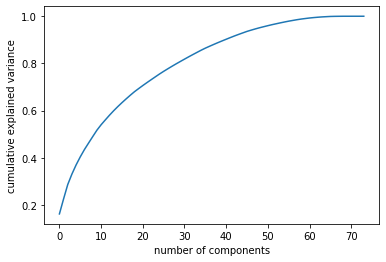

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It is observed that the curve saturates with 62 components, which will be the number of components used

In [26]:
pca = PCA(n_components = 62)
principalComponents = pca.fit_transform(x_train_normal)
x_train_pca = pd.DataFrame(data = principalComponents)

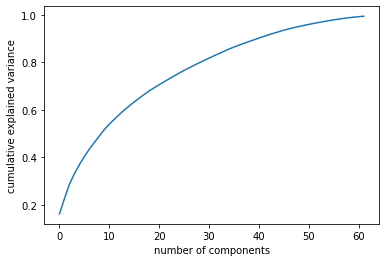

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The PCA is saved

In [28]:
import pickle as pk

with open(directorio + 'data/Modelo/pca_rad.pkl', 'wb') as file:
            pk.dump(pca, file)

Test set

In [29]:
principalComponents = pca.transform(x_test_normal)
x_test_pca = pd.DataFrame(data = principalComponents)

In [30]:
x_train_pca.head()

0         1         2         3         4         5         6   \
0  4.290661  4.611405  0.037406  1.477462  0.629602  3.378059  1.892321   
1  6.437895 -0.588927  0.758448 -0.312902  0.146277 -1.725995  0.278937   
2 -2.103251  3.649262  0.375093  2.443963  0.241470 -0.970866 -0.887252   
3 -5.364588  1.496641  6.776659 -5.434835  0.823635  2.919146  2.520091   
4 -4.407706 -0.766363 -0.050291  0.376756  0.443387  2.828013  2.214977   

         7         8         9         10        11        12        13  \
0 -0.045786 -0.411617 -0.434110 -0.120248 -2.896509  1.152747  1.365923   
1  0.128425 -0.257212  0.128166 -1.101655 -1.447848  0.789297  0.756490   
2  0.408578  0.103171 -0.081969 -1.169864  0.559063 -0.561392 -0.050659   
3 -0.467545 -0.067343 -0.219120 -0.073928  0.193827 -0.768792  1.481535   
4 -0.782017 -0.300021 -0.159830  1.428292  1.639184  0.470693  1.365137   

         14        15        16        17        18        19        20  \
0 -1.267189  0.196661 -0.117636 -0.389483 -1.124068 -0.564629 -1.058085   
1 -2.171826 -0.753687 -1.928257 -0.656254 -1.571672  0.346051 -0.308837   
2  0.778895  1.547174  1.153210  0.221310  0.285923  0.230638  0.146500   
3  0.717178 -1.243531  1.923306 -0.994370 -3.580610  0.280518 -0.164724   
4 -0.496301 -0.837816  0.843507 -0.575590 -0.977811 -1.482176  0.725260   

         21        22        23        24        25        26        27  \
0  1.261965  1.315527 -0.050088  1.298903  0.315043  3.267772 -0.847257   
1  0.135085 -0.089835 -0.305041  0.745537  0.050168  0.823069 -0.534027   
2 -0.191281  0.779898 -0.336625  0.256317 -0.624016  0.614130  1.087087   
3 -0.967452 -2.485524  2.173041  1.225995  0.855689 -4.342742  1.611719   
4 -0.087858 -0.314911 -0.586084  0.474647  1.606974  0.340297 -0.211625   

         28        29        30        31        32        33        34  \
0  0.267210  0.690067  2.790547  0.470906  0.320788 -0.428013  0.291405   
1 -0.601175 -0.040450 -0.018014 -1.664776 -0.449933 -0.199210  0.386418   
2  0.481359 -0.375868  0.482216 -1.328539 -0.801590 -0.100509  0.766372   
3 -0.709860 -0.799119  2.094064 -1.601359  1.129740 -2.008779  1.833352   
4  0.471833 -0.527431 -0.074698  0.010726  0.697217 -0.724251  0.178545   

         35        36        37        38        39        40        41  \
0  0.847337  0.725080  1.700162  1.284900 -0.559849  0.111066 -2.245924   
1 -1.536016  0.784870 -0.646332  1.191906  0.192494  0.611865 -1.053061   
2  1.059710  1.006789 -0.683461 -1.125040 -0.323898 -0.096598 -0.483579   
3  0.960554 -0.082845  0.507479 -0.480922  0.020515  0.160159 -0.068676   
4 -0.224534 -0.063589  0.205910 -0.040890 -0.220486  0.037767 -0.380472   

         42        43        44        45        46        47        48  \
0 -0.018858  0.188327  0.173752  0.426404  0.466625 -0.319768 -0.283366   
1 -0.397181 -0.310768  0.646787 -0.679447  1.495155  0.675221  0.425807   
2 -0.242824 -0.178548 -0.036779  0.884412 -0.808944  0.360974  0.499141   
3 -0.245581  1.270798  0.083118  0.178199  0.084444 -0.162136 -1.443888   
4 -0.727088  1.013039 -0.098309 -0.297824  0.580728  0.054811 -0.165865   

         49        50        51        52        53        54        55  \
0  0.124761 -0.637837  0.048342 -0.215148  0.045711 -0.670536  0.231238   
1  0.223032 -0.738644 -0.297608 -0.246728  0.148626  0.359593 -0.222805   
2 -0.409416  0.892841 -0.414279  0.338420  1.005912 -0.671071 -0.457804   
3  1.431701  0.709342  0.337688  1.398011  0.056810 -0.582502  1.220289   
4 -0.112765 -1.102860 -1.068734 -0.708304  0.060639 -0.638113 -0.327089   

         56        57        58        59        60        61  
0 -0.428937  1.155217  0.552791  0.218724  0.331754 -0.526669  
1 -0.240480 -0.934289  0.396132 -0.234333 -0.136401  0.180143  
2 -1.142799  0.012440  0.326522  0.707908 -0.072195 -0.202190  
3  0.008378 -1.144331 -0.024315 -0.117487 -0.114867  0.497031  
4  0.164359 -0.248857  0.802516 -0.184204  0.459607 -0.360759

In [31]:
x_train_pca.shape

(176478, 62)

In [32]:
x_test_pca.head()

0         1         2         3         4         5         6   \
0  0.622901 -2.203954  0.721012  0.869537  1.391612  1.521385  0.071744   
1 -1.574268 -0.773223  1.270597  0.473407  2.467667 -0.211839 -1.355991   
2 -3.298732  0.263250  4.081078 -2.191195  0.540868  0.253202  0.579005   
3 -5.569342  0.000903  1.013407  1.465727  0.397571  1.357563 -1.029147   
4 -5.649741 -2.177440  3.739819 -1.949683  1.694652  0.251472 -1.279542   

         7         8         9         10        11        12        13  \
0  0.354826 -0.121957  0.123594 -2.169617 -4.273434  1.977578  0.443800   
1 -0.153545 -0.146552 -0.048338  0.403144  1.205595  0.644801  0.586650   
2 -0.122386 -0.096904  0.039439  1.950809 -1.392684 -0.020772  1.890992   
3  0.066883 -0.170128 -0.038249 -0.460814  0.890892  1.186464  0.106690   
4  0.110395  0.156819  0.275978 -1.074014  1.930058  0.802605 -1.594596   

         14        15        16        17        18        19        20  \
0 -2.456360  0.051539 -1.327101  0.377342 -1.789860 -0.568299 -0.182887   
1 -0.509379  0.032431  0.073844 -0.195579  0.354690  0.096876  0.669796   
2  1.050796 -0.264231  0.128625 -1.015122 -0.039339  0.956022  2.009393   
3 -0.288327  0.789159 -0.390983  0.330975  0.824504 -0.584067  0.626897   
4 -1.100157 -0.628359 -1.275473  0.596602  0.070087  0.053223  1.488121   

         21        22        23        24        25        26        27  \
0 -0.504457 -1.401768 -1.230098 -0.670351 -0.366103  0.102080 -1.318313   
1  0.273190 -1.367174  0.182376 -0.905591 -0.598593  0.398697 -0.315857   
2 -3.427097  0.296750 -1.151628  0.652421 -0.512641  3.396979  0.742047   
3  0.171823 -0.091498  0.181231  0.004981 -0.164234 -0.711417  0.758580   
4  1.217489 -1.787874 -0.070657 -0.203807  1.758819  1.338285  0.769437   

         28        29        30        31        32        33        34  \
0 -1.368966  0.180421 -0.331536 -1.626904 -1.563713 -1.925052 -1.534905   
1  0.479916 -0.627695  0.064990  0.390490  0.923655 -0.494404  0.524554   
2 -0.494169 -1.167756 -2.240855  0.548548  0.499390  0.387732 -1.756022   
3 -0.094131 -0.106146 -0.315420  1.130891  1.133485  0.429793  0.581850   
4 -0.433890  0.603444  0.467334  0.764130  0.343056  0.608794  0.944904   

         35        36        37        38        39        40        41  \
0  0.514130  0.757419  1.375003 -0.284104  0.435555 -0.307998 -0.767938   
1  0.667657 -0.627131  0.414903  0.309138  0.589027 -1.231144 -0.151058   
2 -0.540332  0.499559  0.455189 -0.031638 -0.090846  0.388623  0.427986   
3 -1.155135 -0.346094 -1.072822  0.342908 -0.130091  1.050753  0.647363   
4 -0.950580  0.249805  0.013675 -0.240938  0.323729 -1.227646 -0.257573   

         42        43        44        45        46        47        48  \
0  0.956005 -0.244943  0.250759 -0.509880 -0.415292  0.511033  0.118089   
1  0.494247 -0.099157  0.305796 -0.302118  0.350117 -0.108203 -0.158285   
2  0.765211  0.136368  0.580690  0.192910  0.894019 -0.454074  0.804528   
3 -0.054697  0.614388  0.597869 -0.165716 -0.302173  0.605171 -0.436791   
4  0.122243 -0.983479 -0.156526  0.157560  0.016156 -0.012372 -0.230947   

         49        50        51        52        53        54        55  \
0  0.116906 -0.407286  0.233732  0.351935 -0.257535  0.361363  1.046349   
1 -0.317738  0.376668 -0.675562 -0.088843  0.324130 -1.087198 -0.459886   
2 -1.491452  1.779037  0.137500 -0.341453 -0.233003 -0.250046  0.427781   
3  0.622804 -0.039419  0.415378  0.059838 -0.328711 -0.062291  0.933904   
4 -0.545249  0.174004 -0.109778 -0.549688 -0.069395 -0.522907  0.178986   

         56        57        58        59        60        61  
0  0.203131 -0.763423  0.120223  0.663150  0.269420  0.373669  
1  0.651118 -0.402077 -0.039879 -0.026431 -0.321253 -0.184117  
2 -0.329407 -0.409712  0.580144 -0.220794  0.112742  0.574989  
3  0.672962  0.329520  0.830638 -0.666895 -0.579260 -0.667304  
4  0.305524  0.813317  0.009555  0.382892 -0.246633 -0.137888

In [33]:
x_test_pca.shape

(75634, 62)

### Sanity check

It is checked if any of the components does not follow a normal distribution

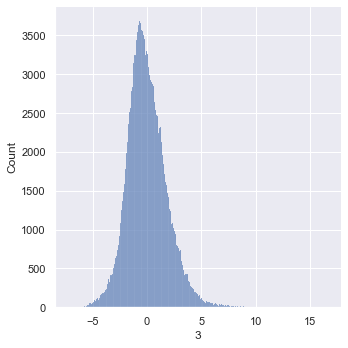

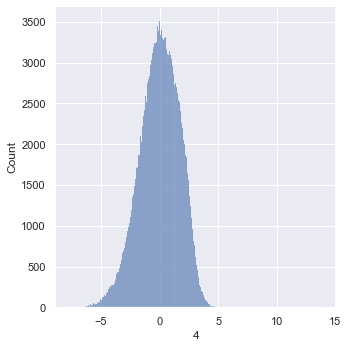

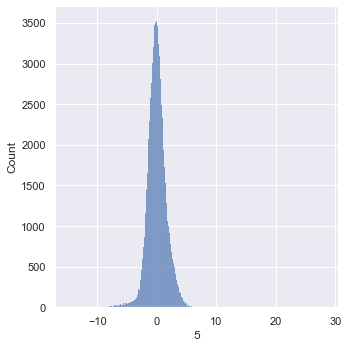

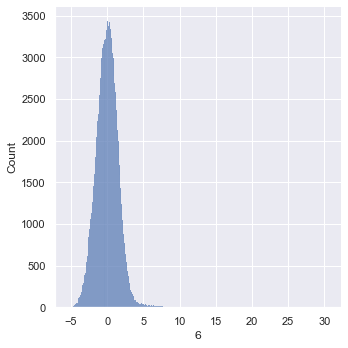

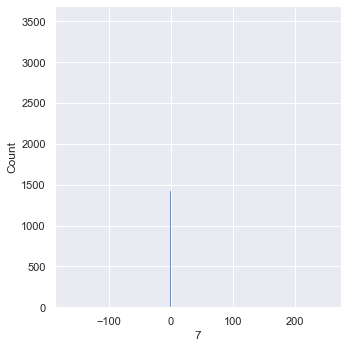

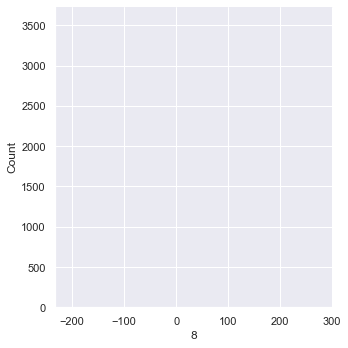

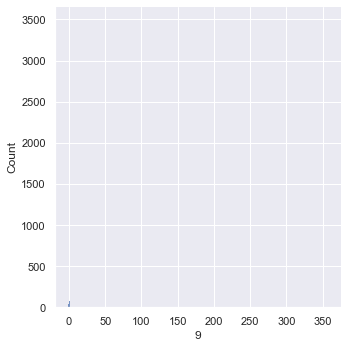

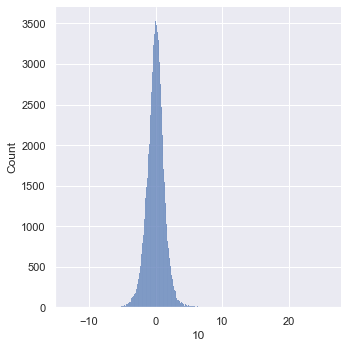

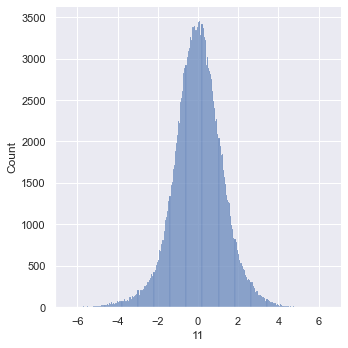

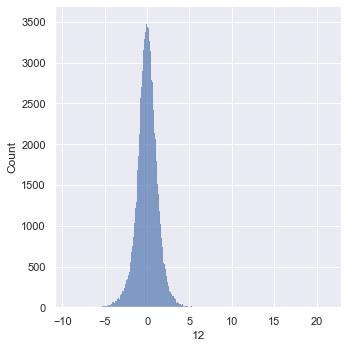

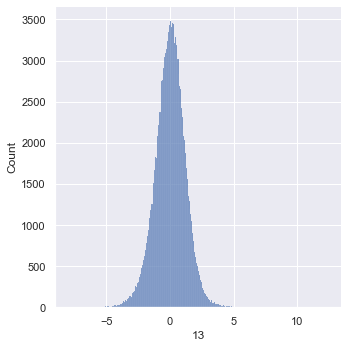

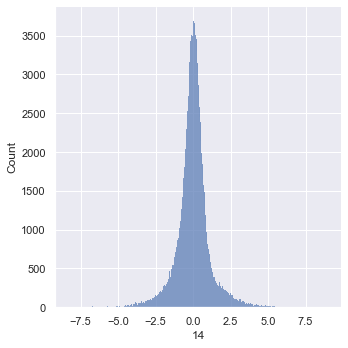

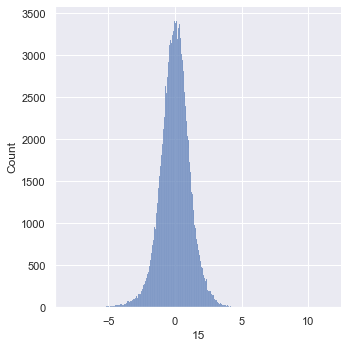

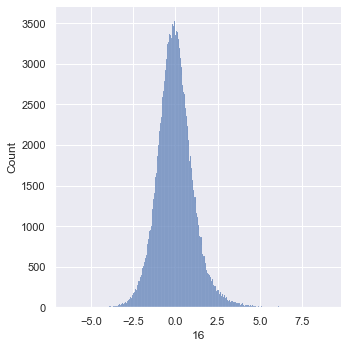

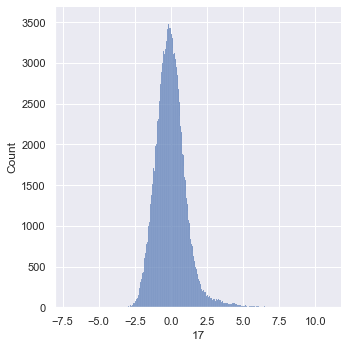

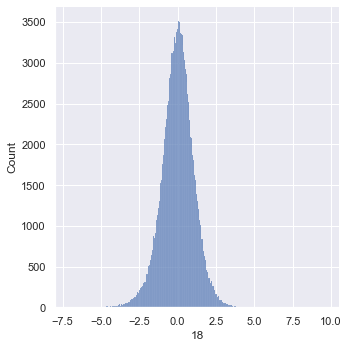

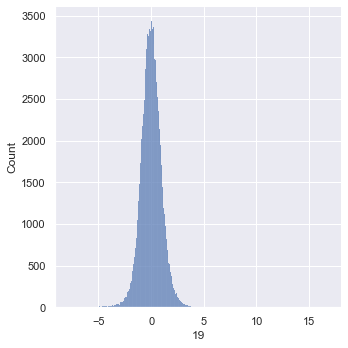

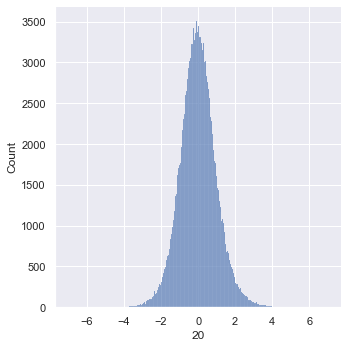

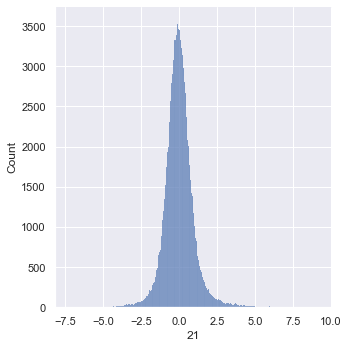

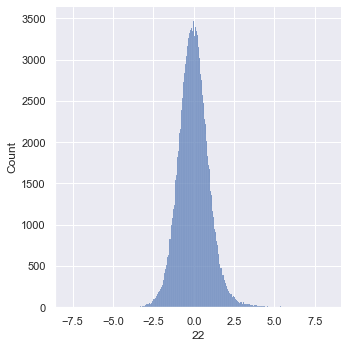

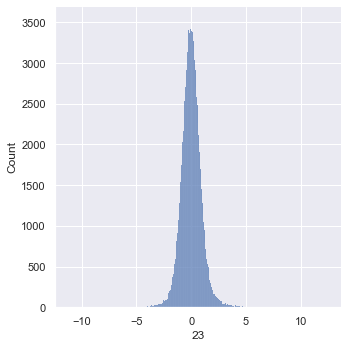

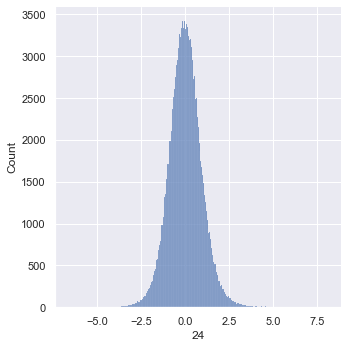

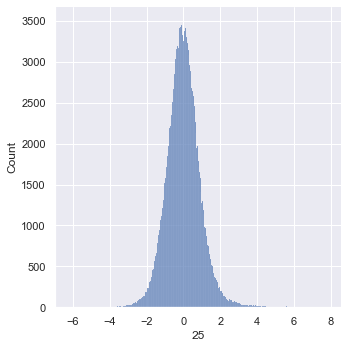

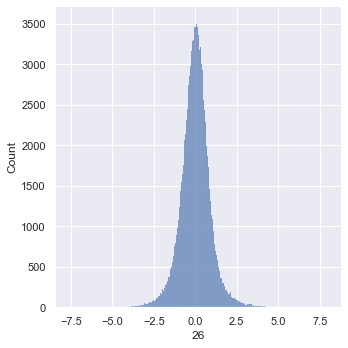

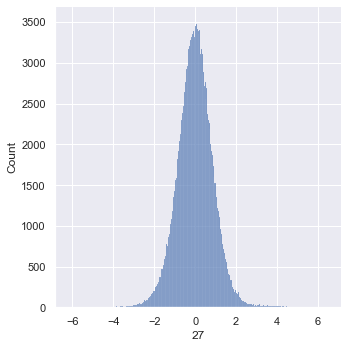

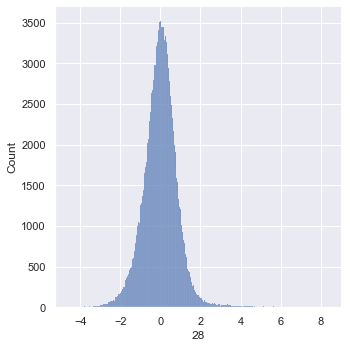

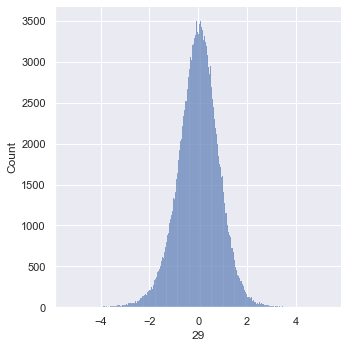

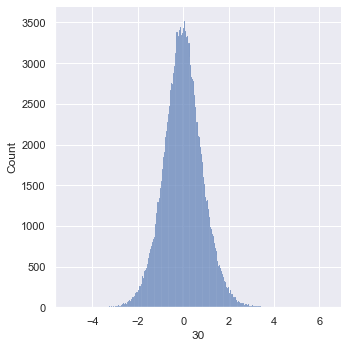

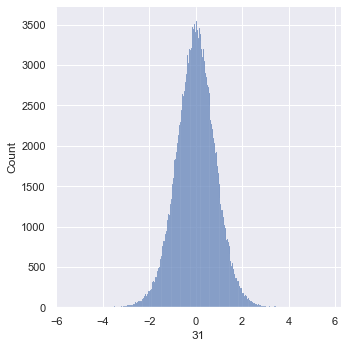

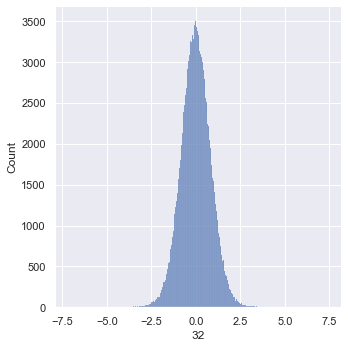

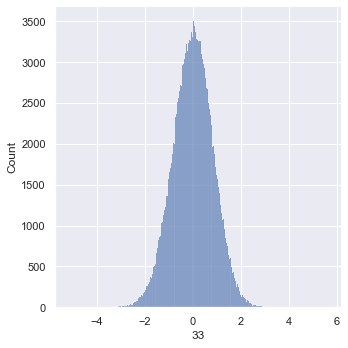

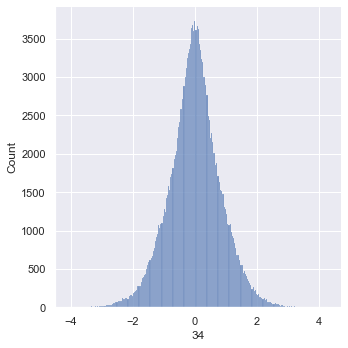

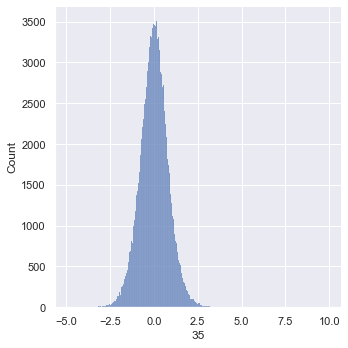

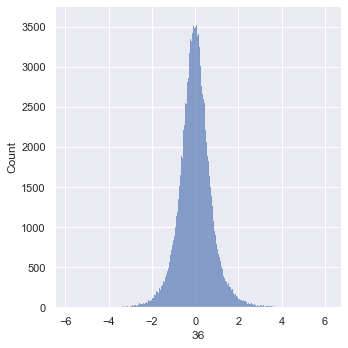

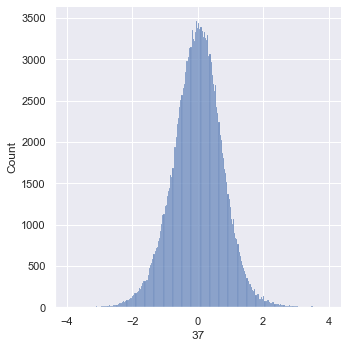

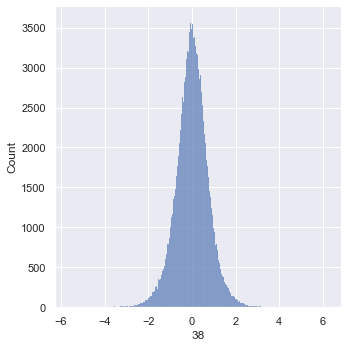

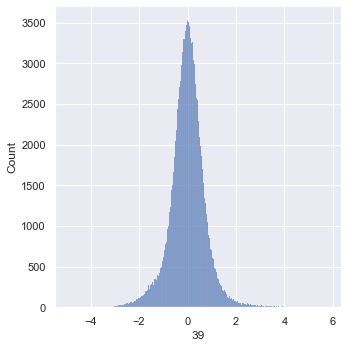

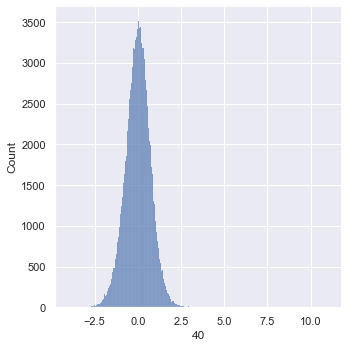

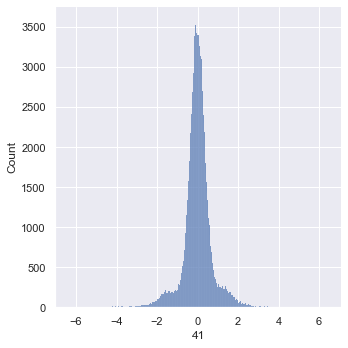

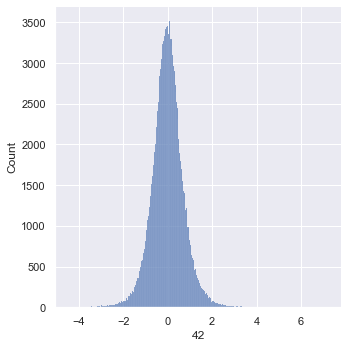

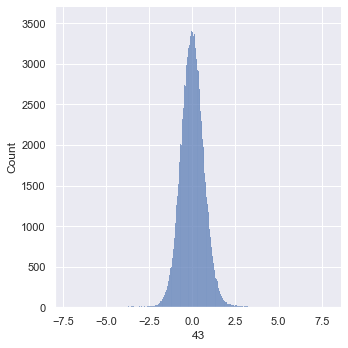

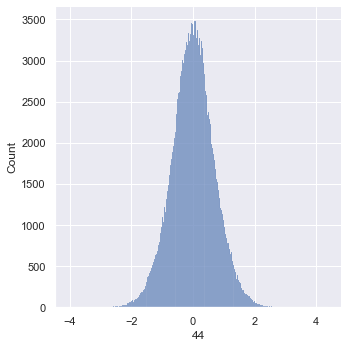

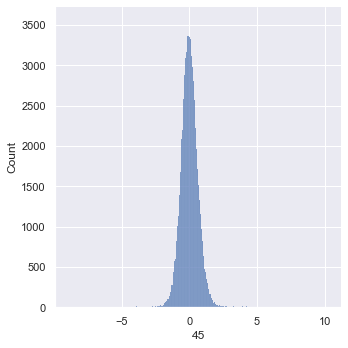

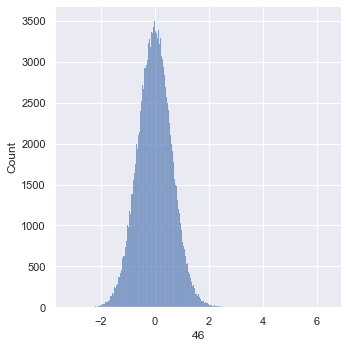

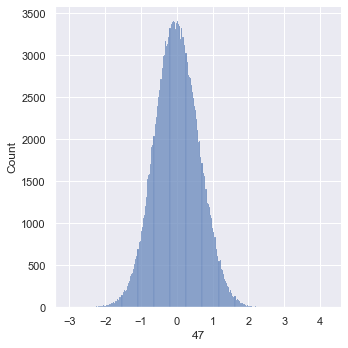

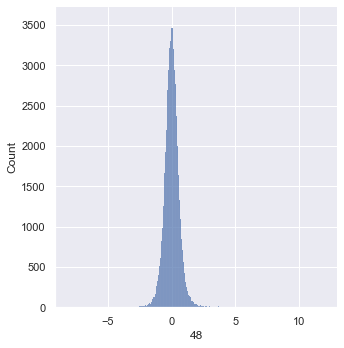

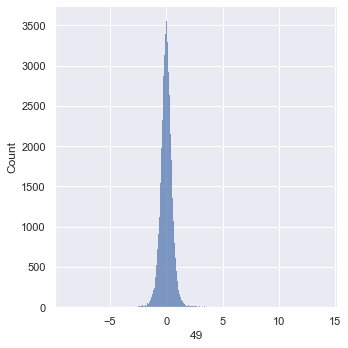

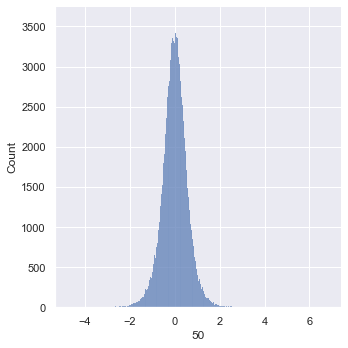

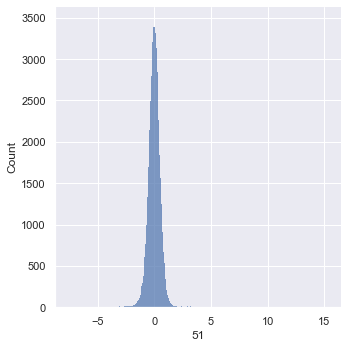

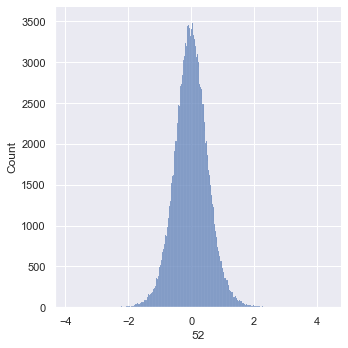

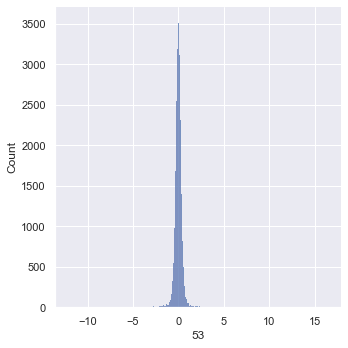

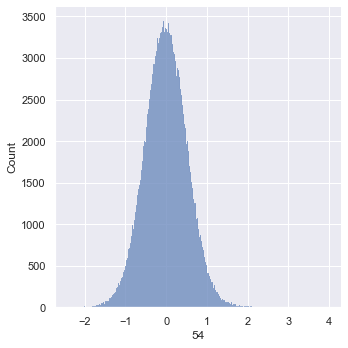

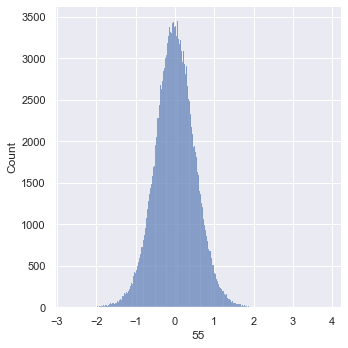

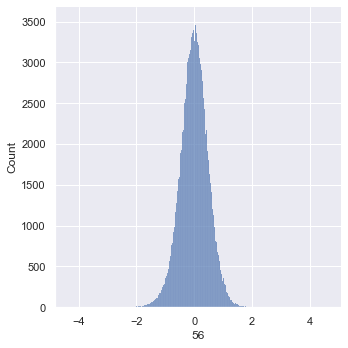

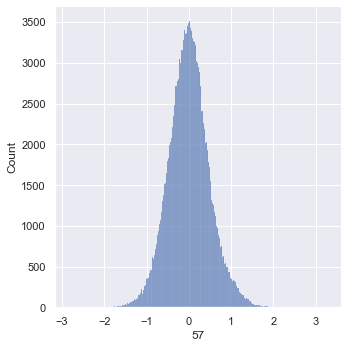

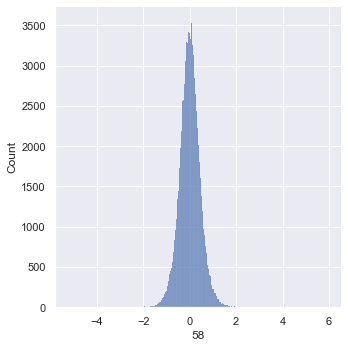

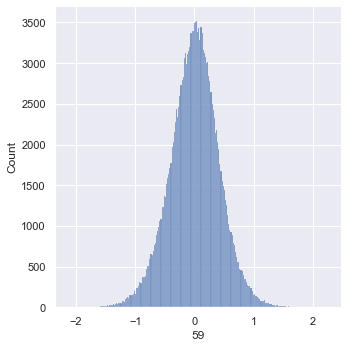

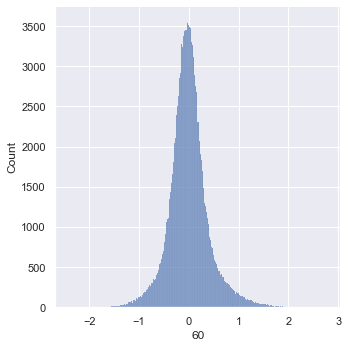

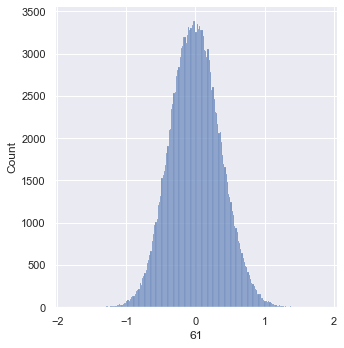

In [34]:
for i in range(3, len(x_train_pca.columns)):
    sns.set()
    cols = list(x_train_pca.columns)[i]
    sns.displot(x_train_pca[cols])
    plt.show();

It is verified that none of the variables requires the use of Yeo-Johnson or Box-Cox transformations

It is verified that the different components have no relation to each other

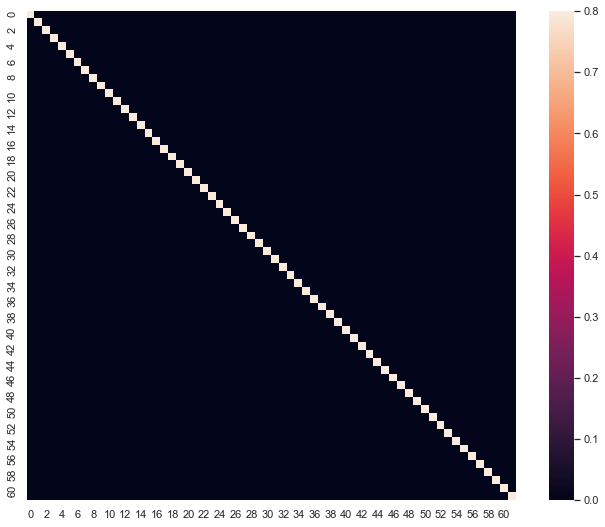

In [35]:
corrmat = x_train_pca.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True);

# Base model

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

A first model is generated as a basis for comparisons. It simply gets the hourly mean value of the target variable, assigning the predicted value based on the hour of the input data

In [36]:
# Data to use
datos_media = df[columnas_minimas]

# The means per hour are obtained
datos_media = datos_media.groupby(columnas_minimas[:-1]).mean()
datos_media

ghi
hora            
4       0.924537
5      34.644743
6     142.381474
7     295.236692
8     453.658388
9     594.056214
10    704.684429
11    784.561103
12    802.498254
13    739.944608
14    657.547343
15    533.123471
16    387.849274
17    231.120101
18     89.789610
19      9.763297

In [37]:
def modelo_medias_hora(datos, x_test):
    datos = pd.DataFrame(datos).reset_index()
    
    # The columns of interest are selected
    x_test = x_test[columnas_minimas[:-1]]
    
    # Average value per hour is assigned
    predicciones = []
    [predicciones.append([datos[datos[columnas_minimas[:-1][0]] == fila[columnas_minimas[:-1][0]]][[columnas_objetivo[0]]][columnas_objetivo[0]].iloc[0]][0]) for index,fila in x_test.iterrows()]

    return predicciones

In [38]:
pred_media = modelo_medias_hora(datos_media, x_test)
pred_media[:1000]

[89.78960972001806,
 231.12010136429964,
 657.5473434308161,
 533.1234708156385,
 387.84927354618014,
 739.9446080403618,
 295.23669230915647,
 89.78960972001806,
 704.684429012581,
 657.5473434308161,
 453.6583877640354,
 739.9446080403618,
 453.6583877640354,
 295.23669230915647,
 739.9446080403618,
 802.4982536007167,
 657.5473434308161,
 739.9446080403618,
 533.1234708156385,
 0.9245370612503953,
 142.3814737255897,
 453.6583877640354,
 784.5611028190536,
 295.23669230915647,
 295.23669230915647,
 0.9245370612503953,
 784.5611028190536,
 453.6583877640354,
 453.6583877640354,
 704.684429012581,
 142.3814737255897,
 9.763296630069181,
 594.0562142965933,
 739.9446080403618,
 231.12010136429964,
 9.763296630069181,
 784.5611028190536,
 784.5611028190536,
 295.23669230915647,
 89.78960972001806,
 784.5611028190536,
 453.6583877640354,
 739.9446080403618,
 231.12010136429964,
 0.9245370612503953,
 34.644742500954216,
 387.84927354618014,
 453.6583877640354,
 387.84927354618014,
 0.9245

Some example prediction values are visually compared

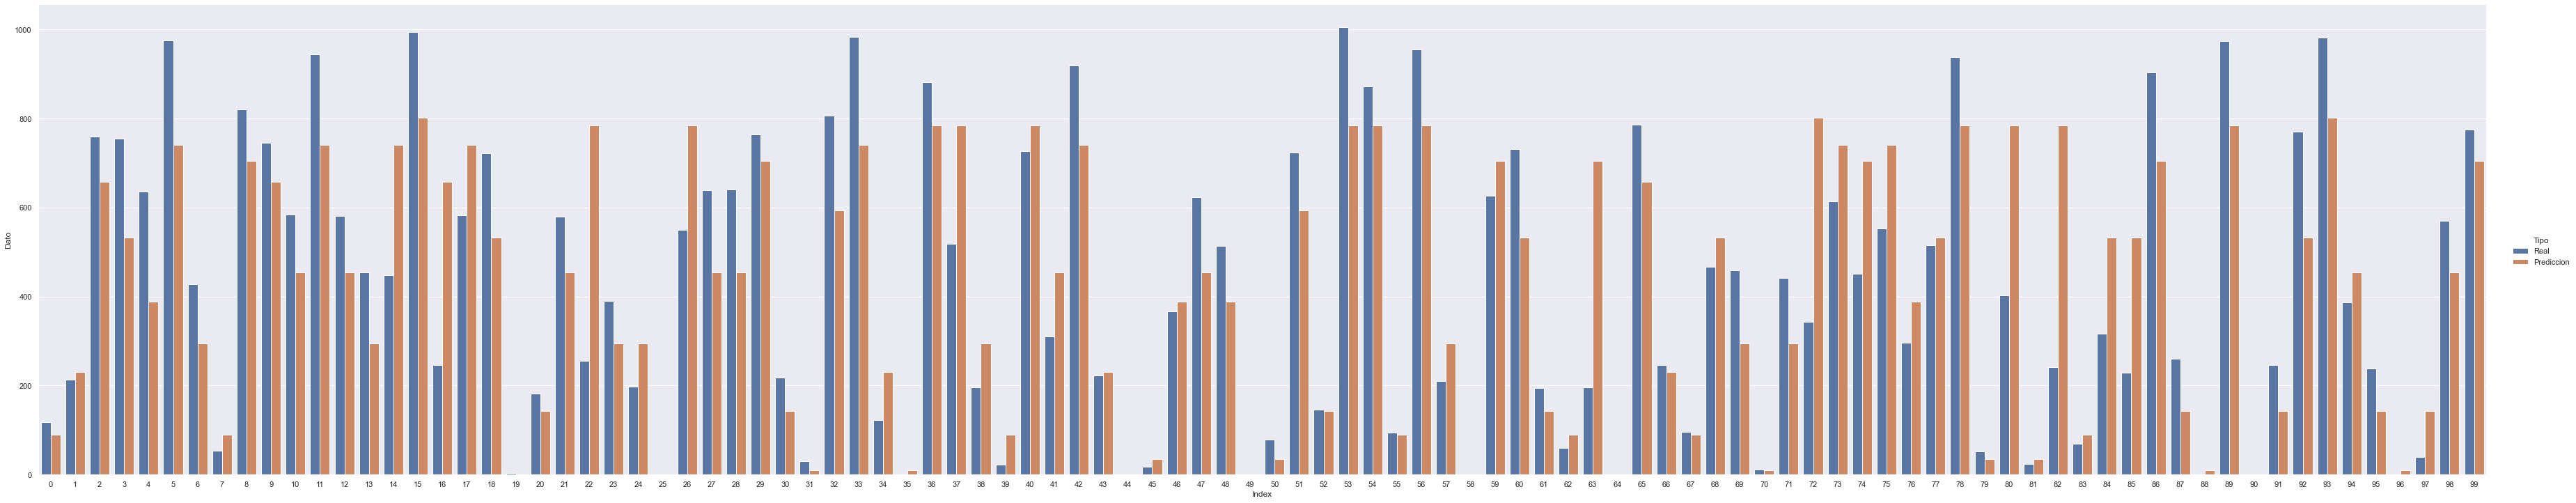

In [39]:
y_test_ = list(y_test.iloc[:,0])
graf_compara('Hourly averages model', y_test_[:100], pred_media[:100])

Prediction values and overall trend of target values are visually compared

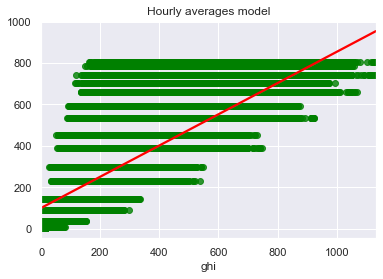

In [40]:
sns.regplot(x = y_test, y = pred_media,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Hourly averages model');

The metrics are obtained from the model results

In [41]:
metricas_media = metricas('Hourly averages model', y_test, pred_media)

MODEL:  Hourly averages model
MAE:  117.92546671774807
MSE:  161.5773325059358
RMSE:  161.5773325059358
R2 :  0.7551160503095614


In [42]:
x_train = x_train_pca
x_test = x_test_pca

# Linear regression

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

It is used to estimate real values based on continuous variables. Here, the relationship between the independent and dependent variables is established by a line. This line of fit is known as the regression line and is represented by a linear equation: ``Y = a * X + b``.

In [43]:
from sklearn.linear_model import LinearRegression

# The model is created and trained
regre = LinearRegression()
regre.fit(x_train, y_train)

# The prediction is obtained
pred_reg_lineal_ = regre.predict(x_test)

In [44]:
pred_reg_lineal = []
[pred_reg_lineal.append(y[0]) for y in pred_reg_lineal_.tolist()]
pred_reg_lineal[:1000]

[115.19427290202833,
 114.5080057084158,
 619.6719015904976,
 648.6591951612636,
 550.4378247541438,
 1096.9732807184496,
 362.9841106847548,
 -35.44955404748214,
 752.4891153590033,
 601.7141984085611,
 249.84344899429865,
 756.7836776233568,
 459.0996306210902,
 298.91845608587073,
 793.449518136365,
 828.0290398914276,
 678.448912841893,
 604.38334671541,
 474.5552616437931,
 20.24231832292719,
 141.95935754306493,
 245.72999026318365,
 598.0434679939397,
 331.9362368170863,
 67.88396914438482,
 135.24463130708546,
 658.8451683634773,
 341.74760523269293,
 575.2884509984461,
 627.0077956386929,
 208.21824187728126,
 106.07666246123546,
 725.0330360976917,
 1029.6223117225998,
 96.67778237711826,
 65.23256380546951,
 692.9766538673227,
 627.1965577763315,
 211.99228990191153,
 59.40712049053951,
 778.8922310513855,
 168.77491864710322,
 616.2112770338906,
 143.69918828839815,
 64.43021411888202,
 109.57179425311728,
 481.01647639296135,
 529.2443432782242,
 401.4605759810024,
 40.219

Some example prediction values are visually compared

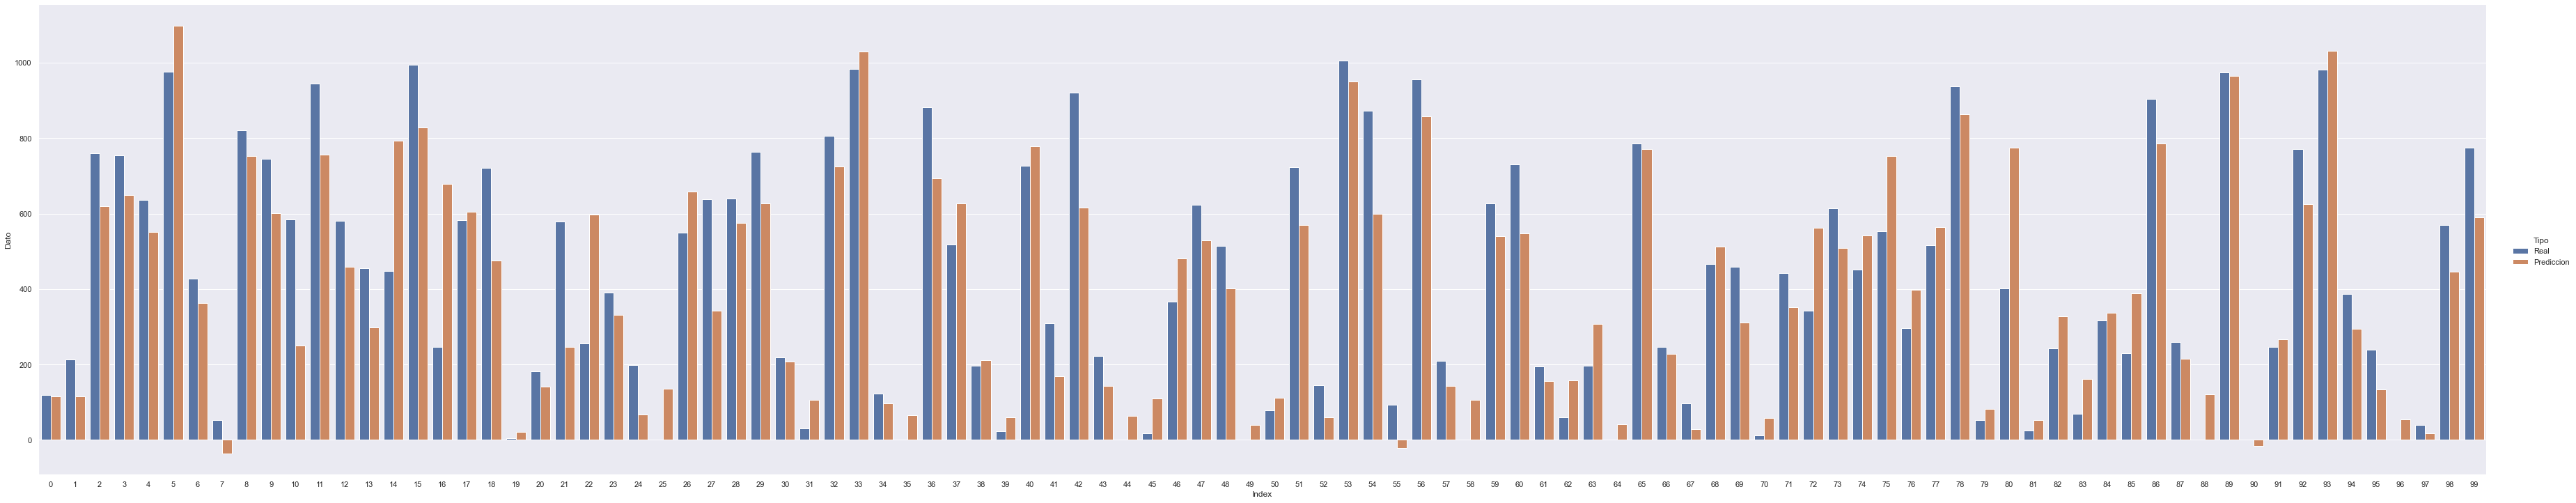

In [45]:
graf_compara('Linear regression model', list(y_test[columnas_objetivo[0]])[:100], pred_reg_lineal[:100])

Prediction values and overall trend of target values are visually compared

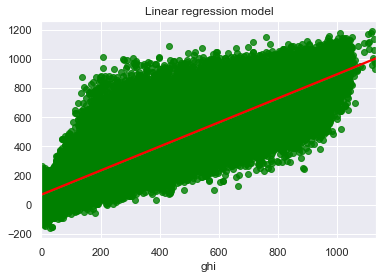

In [46]:
sns.regplot(x = y_test, y = pred_reg_lineal,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Linear regression model');

The metrics are obtained from the model results

In [47]:
metricas_regresion_lineal = metricas('Linear regression model', y_test, pred_reg_lineal)

MODEL:  Linear regression model
MAE:  101.2822909191304
MSE:  137.02972171228657
RMSE:  137.02972171228657
R2 :  0.8238717562096077


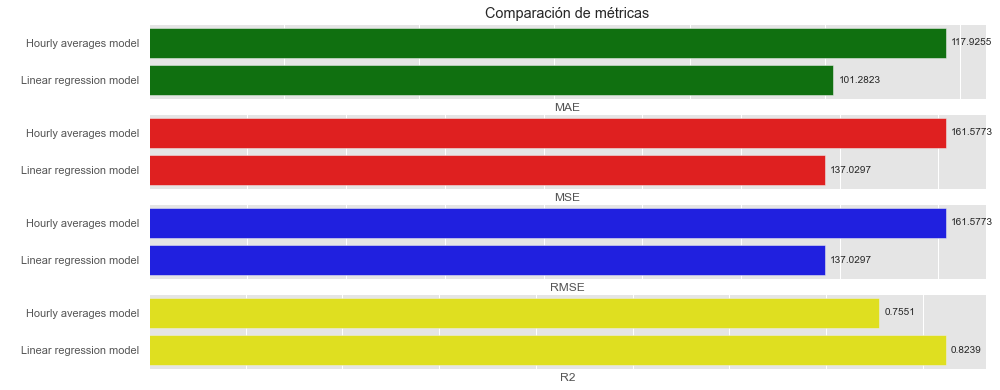

In [48]:
compracion_metricas([metricas_media,
                     metricas_regresion_lineal])

# k-Nearest Neighbors

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

It can be used for both classification and regression problems. kNN is a simple algorithm that stores all available cases and classifies new cases by majority vote of their k neighbors. The case assigned to the class is the most common among its K closest neighbors measured by a distance function

[None]

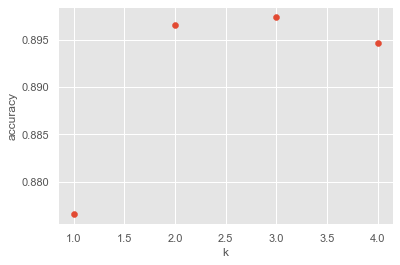

In [49]:
from sklearn.neighbors import KNeighborsRegressor

# For a range of number of neighboring points, the precision of the model is plotted
k_range = range(1, (len(x_train) if 5 > len(x_train) else 5))
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    knn.fit(x_train, y_train)
    scores.append(knn.score(x_test, y_test))
plt.figure();
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores);
k_ideal = []
[k_ideal.append(list(k_range)[i]) for i in range(0, len(scores)) if scores[i] == np.max(scores)]

In [50]:
from sklearn.neighbors import KNeighborsRegressor

# The model is created and trained with the k value obtained
knn = KNeighborsRegressor(n_neighbors = k_ideal[0], weights = 'uniform')

knn.fit(x_train, y_train)

# The prediction is obtained
pred_knn_ = knn.predict(x_test)

In [51]:
pred_knn = []
[pred_knn.append(y[0]) for y in pred_knn_.tolist()]
pred_knn[:10000]

[124.12723333333334,
 16.3066,
 762.0446666666667,
 690.9464666666667,
 662.3218999999999,
 956.8168000000001,
 356.64826666666664,
 53.70646666666667,
 815.8711,
 837.1146666666667,
 426.70689999999996,
 939.0541,
 630.8772,
 566.4372666666667,
 305.0538666666667,
 1003.0323666666667,
 347.1221666666667,
 601.4386666666667,
 721.9586333333333,
 26.918966666666666,
 84.60206666666666,
 578.4085333333334,
 350.5433666666666,
 523.9413666666668,
 49.02903333333333,
 39.09246666666667,
 370.4884333333334,
 452.4327666666666,
 519.0346,
 820.1225333333333,
 347.4705666666667,
 75.4678,
 790.8338333333335,
 874.4029,
 159.86733333333333,
 71.6519,
 818.6121666666668,
 584.9176666666666,
 312.0845,
 0.0,
 803.4546,
 127.46663333333335,
 764.2618333333334,
 206.40203333333332,
 90.46503333333334,
 79.06103333333333,
 502.98483333333326,
 541.6049666666667,
 504.4089000000001,
 1.0270666666666666,
 46.33133333333333,
 711.8398000000001,
 62.48736666666667,
 992.3483,
 736.5966,
 137.0431999999

Some example prediction values are visually compared

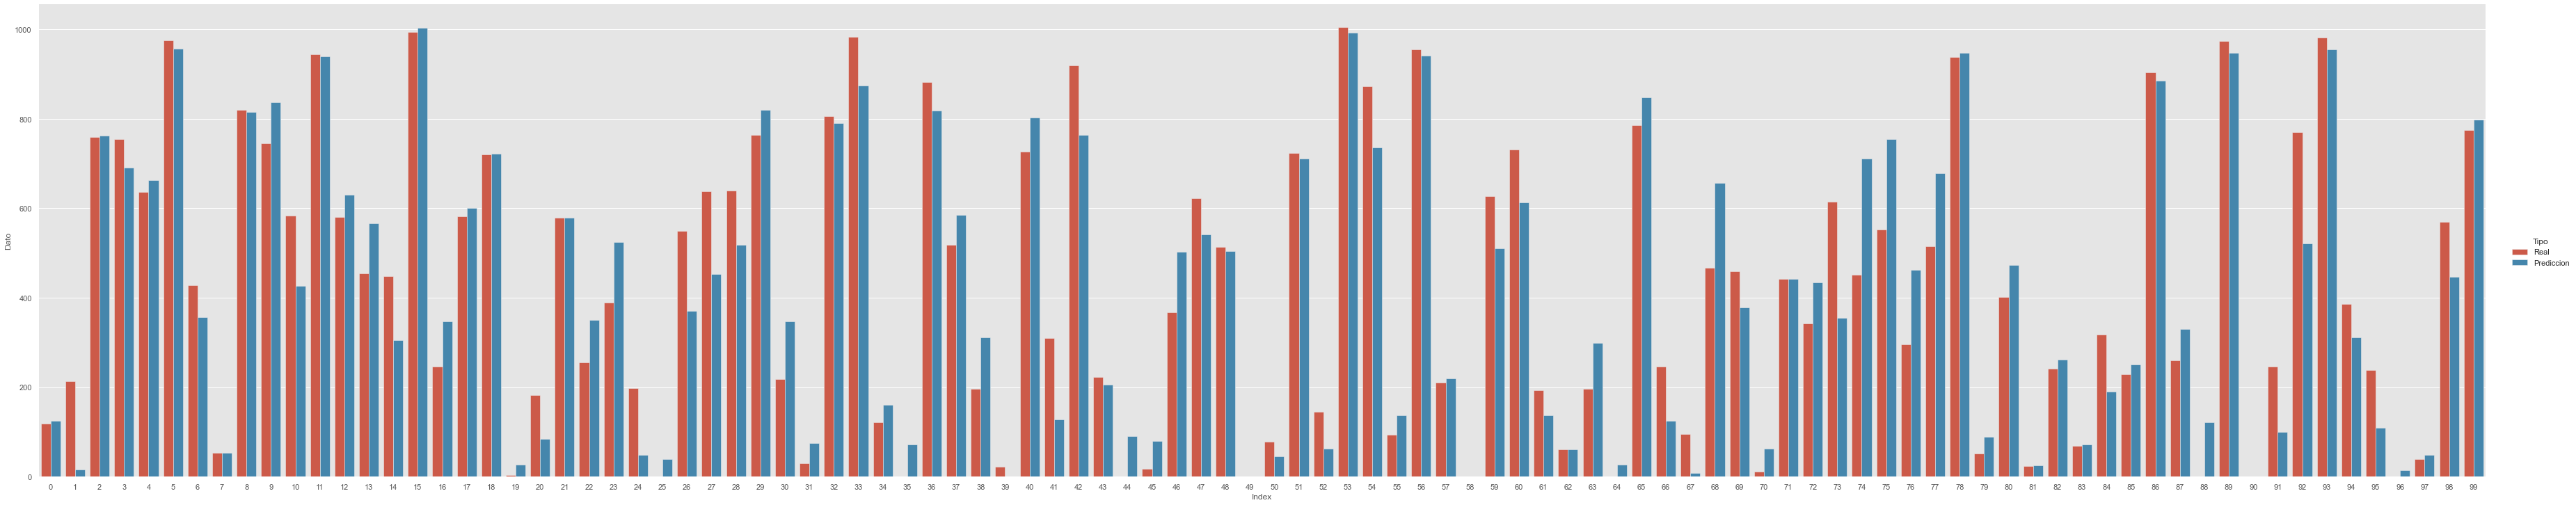

In [52]:
graf_compara('Knn model', list(y_test[columnas_objetivo[0]])[:100], pred_knn[:100])

Prediction values and overall trend of target values are visually compared

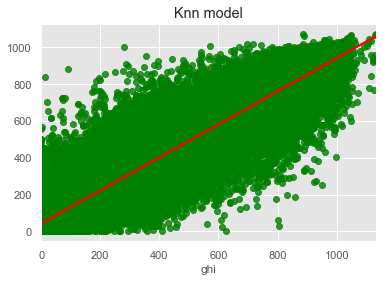

In [53]:
sns.regplot(x = y_test, y = pred_knn,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Knn model');

The metrics are obtained from the model results

In [54]:
metricas_knn = metricas('Knn model', y_test, pred_knn)

MODEL:  Knn model
MAE:  70.60110349710449
MSE:  104.57174086461569
RMSE:  104.57174086461569
R2 :  0.8974281640120632


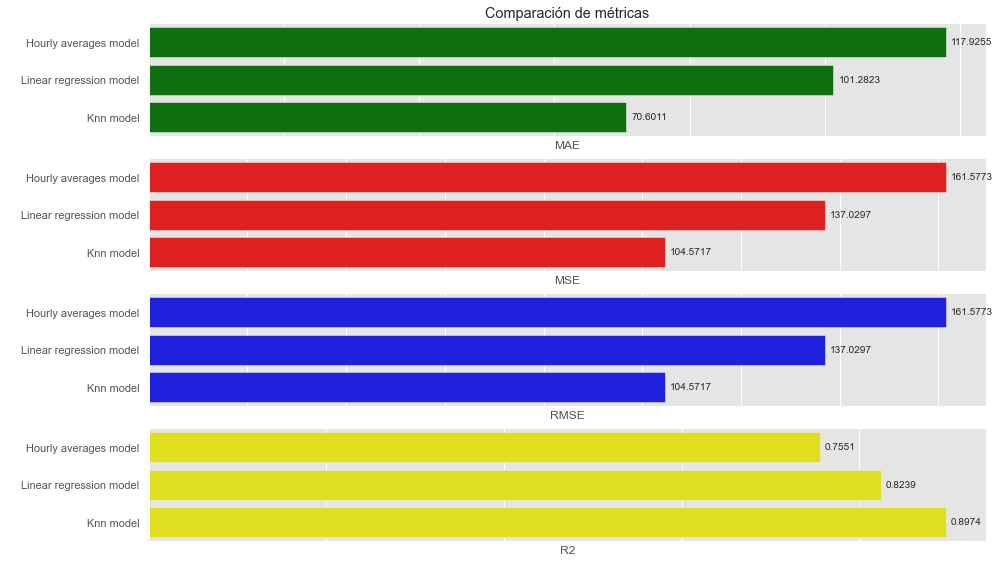

In [55]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn])

# Decision tree

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

It is a type of supervised learning algorithm that works for both categorical and continuous dependent variables. It is a predictive model that divides the space of the predictors by grouping observations with similar values for the response or dependent variable

In [56]:
from sklearn.tree import DecisionTreeRegressor

# The model is created and trained
tree = DecisionTreeRegressor (max_depth = 20,
                              min_samples_leaf = 15)

tree.fit(x_train, y_train)

# The prediction is obtained
pred_tree_ = tree.predict(x_test)

In [57]:
pred_tree = []
[pred_tree.append(y) for y in pred_tree_.tolist()]
pred_tree[:1000]

[95.58933750000003,
 95.71604666666666,
 815.5131962962963,
 767.4908400000002,
 596.2122954545456,
 976.4982856321843,
 475.121111764706,
 34.99678260869565,
 894.3838949999997,
 534.3462166666667,
 538.9242333333334,
 907.4186599999999,
 646.8593750000001,
 46.442032142857144,
 566.8959142857142,
 940.2401800000001,
 284.739092,
 655.0360266666667,
 664.9477812499999,
 17.804957142857145,
 84.6522857142857,
 457.8827866666668,
 707.0971035714284,
 636.379992,
 86.97899999999998,
 21.664768181818186,
 484.5824705882353,
 274.5944652173913,
 651.3829956521738,
 816.0286764705882,
 345.5107777777778,
 30.199294117647053,
 945.3416840000004,
 941.3178823529411,
 88.35985333333335,
 74.69296428571428,
 821.407125,
 709.2432235294118,
 142.83174,
 76.34421176470589,
 603.1435937499999,
 94.58792666666666,
 841.3617124999998,
 30.199749999999998,
 3.0993608478802996,
 19.002539285714285,
 546.6806882352942,
 575.5785666666667,
 453.0719888888889,
 12.305305000000002,
 98.11118461538462,
 80

Some example prediction values are visually compared

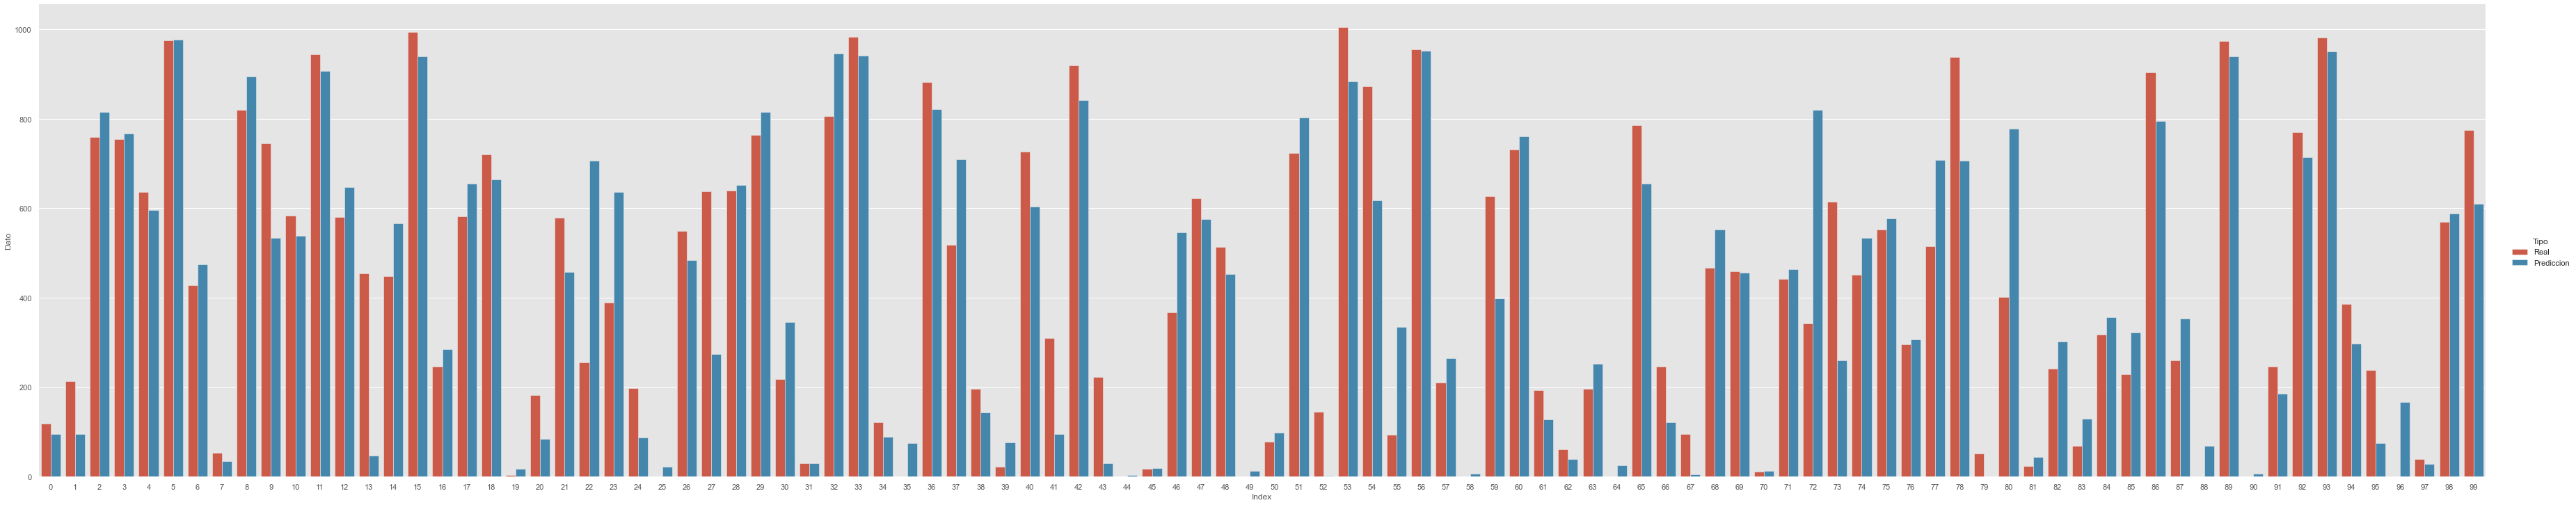

In [58]:
graf_compara('Decision tree model', list(y_test[columnas_objetivo[0]])[:100], pred_tree[:100])

Prediction values and overall trend of target values are visually compared

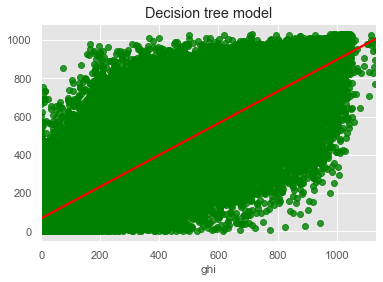

In [59]:
sns.regplot(x = y_test, y = pred_tree,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Decision tree model');

The metrics are obtained from the model results

In [60]:
metricas_tree = metricas('Decision tree model', y_test, pred_tree)

MODEL:  Decision tree model
MAE:  109.97345881373015
MSE:  156.91518549421792
RMSE:  156.91518549421792
R2 :  0.7690439186133557


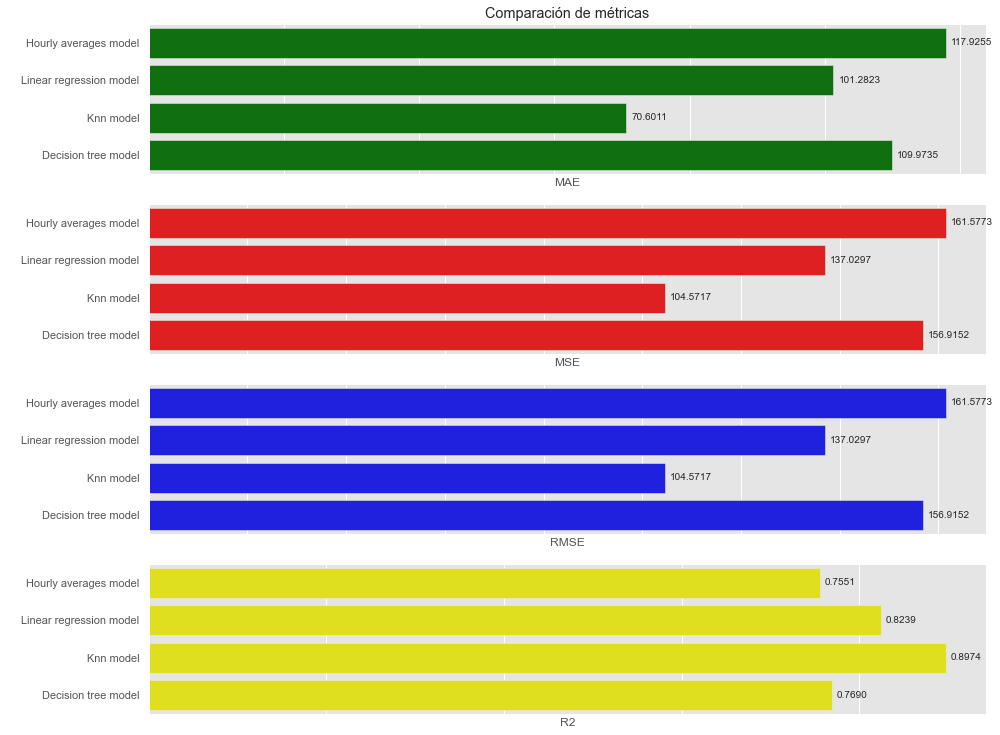

In [61]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree])

# Polynomial regression

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

**NOT USED**: CAUSES MEMORY PROBLEMS

It is a special case of linear regression, it extends the linear model by adding additional predictors, obtained by raising each of the original predictors to a power. For example, a cubic regression uses three variables, as predictors. This approach provides a simple way to provide a nonlinear fit to the data

In [62]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 

# The estimator is generated

class PolynomialRegression(BaseEstimator):
    def __init__(self, deg = None):
        self.deg = deg
            
    def fit(self, x, y, deg = None):
        self.model = LinearRegression()
        poli = PolynomialFeatures(degree = self.deg)
        x_ = poli.fit_transform(x)
        self.model.fit(x_, y)
    
    def predict(self, x):
        poli = PolynomialFeatures(degree = self.deg)
        x_ = poli.fit_transform(x)
        return self.model.predict(x_)

    def coef_(self):
        return pol_reg.coef_
    
    def best_params_(self):
        return pol_reg.best_params_

In [63]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression

# The model is created and trained

#pol_reg = LinearRegression()
#poli = PolynomialFeatures(degree = 2)
#x_train_pol = poli.fit_transform(x_train)
#x_test_pol = poli.fit_transform(x_test)
#pol_reg.fit(x_train_pol, y_train)

#pred_pol_reg_ = pol_reg.predict(x_test_pol)

# Gradient boosting

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

Gradient boosting is a machine learning technique used for regression analysis and classification problems, which produces a predictive model in the form of a set of weak prediction models, typically decision trees. It builds the model in a stepwise fashion like other boosting methods do, and generalizes them by allowing arbitrary optimization of a differentiable loss function

In Gradient Boosting, the number of trees is a critical hyperparameter in that, as trees are added, the risk of overfitting increases

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

# The model is created and trained
gbm = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = 123
         )

gbm.fit(x_train, y_train.values.ravel())

# The prediction is obtained
pred_gbm_ = gbm.predict(x_test)

In [73]:
pred_gbm = []
[pred_gbm.append(y) for y in pred_gbm_.tolist()]
pred_gbm[:1000]

[274.69102278823397,
 593.1065740174323,
 378.167168979302,
 609.7537367194557,
 206.2318539877585,
 638.7529225014327,
 605.8053796814617,
 264.100062929366,
 247.64189533697922,
 631.1282724023695,
 231.09594666779213,
 414.6600878286264,
 392.9859271636455,
 522.2493613250094,
 262.63492475817196,
 313.2212124881981,
 182.74210359312886,
 278.34983533167735,
 229.16309362892608,
 232.4592621797855,
 224.74488743331366,
 328.20377962400244,
 235.92994500615933,
 271.9329042309379,
 488.8023019528553,
 284.94318264633137,
 303.96131570061107,
 257.31891972578524,
 638.7529225014327,
 519.0283500842105,
 242.170230959824,
 609.7537367194557,
 359.29793363794454,
 261.27350378206967,
 384.82776922519133,
 528.6065506848596,
 245.80351220504667,
 257.31891972578524,
 315.6878887436684,
 222.28320574566268,
 400.82851272563244,
 281.17525957203685,
 407.85604243876486,
 219.86198368705018,
 279.59780858227816,
 389.6397688381276,
 243.59487751561684,
 199.97181088046446,
 205.323616750341

Some example prediction values are visually compared

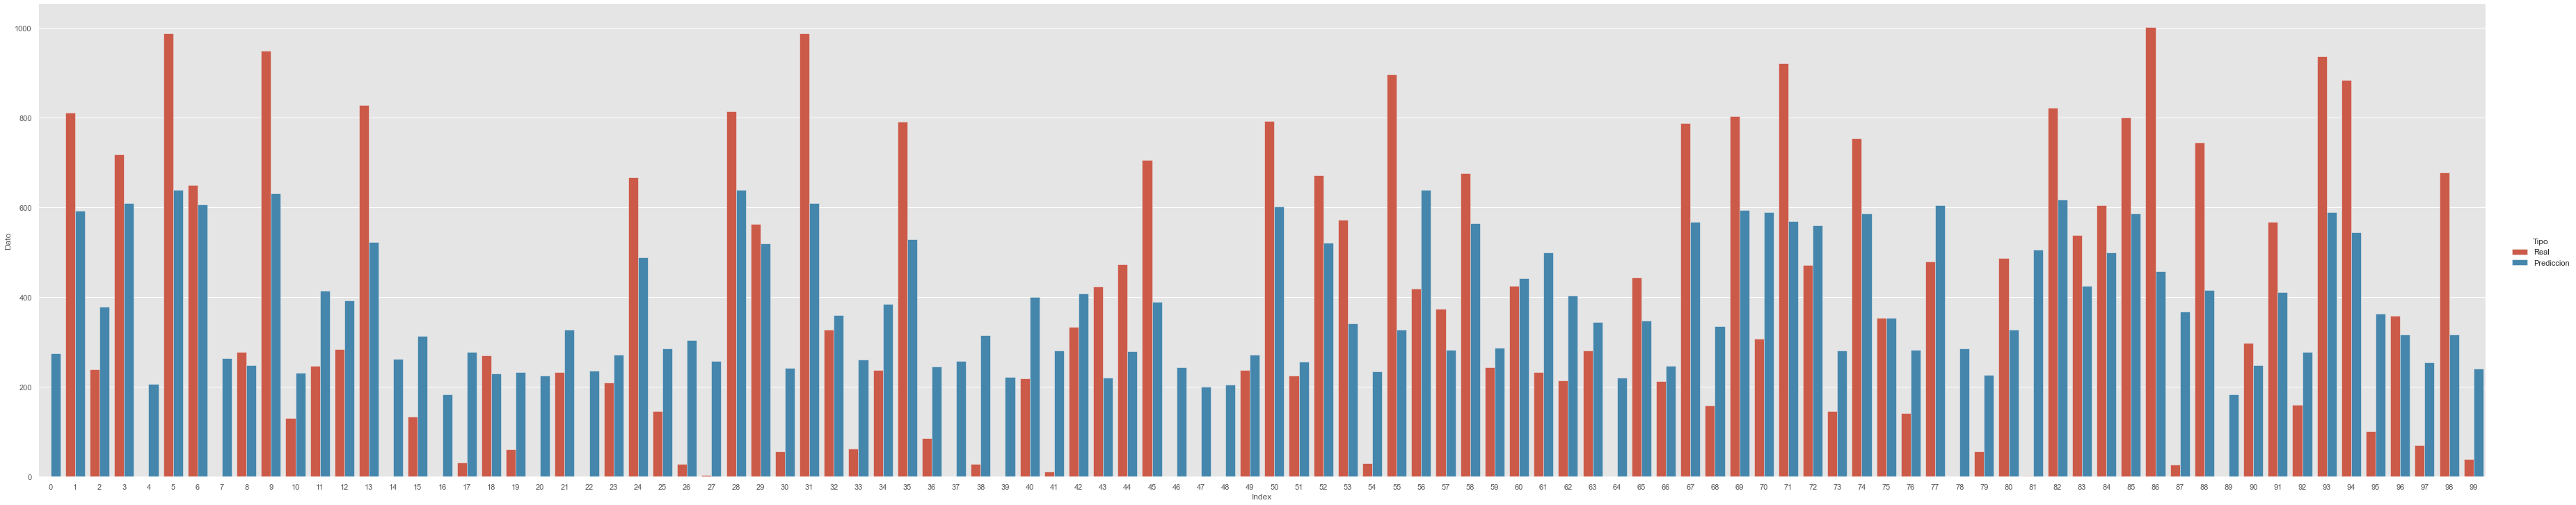

In [74]:
graf_compara('Gradient boosting model', list(y_test[columnas_objetivo[0]])[:100], pred_gbm[:100])

Prediction values and overall trend of target values are visually compared

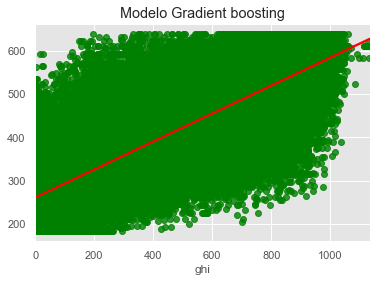

In [75]:
sns.regplot(x = y_test, y = pred_gbm,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Gradient boosting model');

The metrics are obtained from the model results

In [76]:
metricas_gbm = metricas('Gradient boosting model', y_test, pred_gbm)

MODEL:  Modelo de Gradient boosting
MAE:  201.54200091646044
MSE:  232.44077346583924
RMSE:  232.44077346583924
R2 :  0.4763345991107423


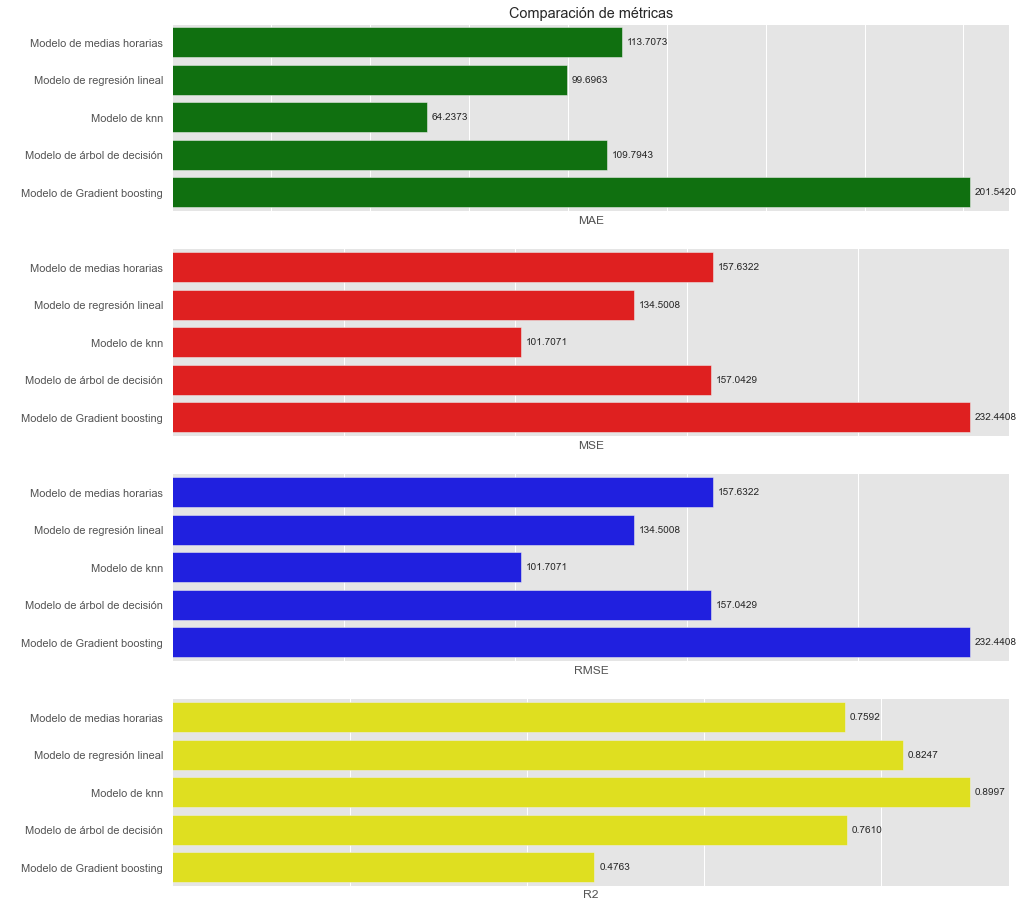

In [77]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm])

# Random forest

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

Random forest (or random forests) is a combination of predictor trees such that each tree depends on the values of a random vector tested independently and with the same distribution for each of these. It is a substantial modification of bagging that builds a long collection of uncorrelated trees and then averages them

In [80]:
from sklearn.ensemble import RandomForestRegressor

# The model is created and trained
# n_jobs: -1 means using all processors
forest = RandomForestRegressor(max_depth = None,
                              min_samples_leaf = 1,
                              n_estimators = 100,
                              n_jobs = -1)
                            
forest.fit(x_train,y_train.values.ravel())

# The prediction is obtained
pred_forest_ = forest.predict(x_test)

In [81]:
pred_forest = []
[pred_forest.append(y) for y in pred_forest_.tolist()]
pred_forest[:1000]

[28.158758,
 766.4829420000002,
 278.66901299999984,
 841.7019899999999,
 36.549568,
 915.4642379999996,
 924.6833509999993,
 22.181800000000003,
 169.60107600000003,
 961.3107869999999,
 131.13023399999992,
 292.60790000000003,
 281.33678199999997,
 691.5443299999997,
 32.485151,
 167.12864599999997,
 6.009358999999998,
 25.645638999999978,
 191.03508500000004,
 97.830863,
 9.091156999999999,
 297.60088699999994,
 2.091868,
 164.346019,
 635.4104939999996,
 167.20682999999997,
 77.36863700000002,
 214.45838700000002,
 786.0689550000003,
 524.8256649999997,
 112.71055799999998,
 925.5401379999997,
 347.8692810000003,
 122.49346000000006,
 292.00269600000007,
 691.5972470000004,
 214.54588200000006,
 53.11312000000002,
 99.98227000000003,
 17.44918,
 229.56737299999986,
 17.627723000000003,
 322.0617080000001,
 384.2478490000001,
 379.7808189999999,
 730.728587,
 146.99393699999996,
 23.843144999999996,
 26.965861999999987,
 211.78146000000004,
 682.483643,
 156.82592200000002,
 607.343

Some example prediction values are visually compared

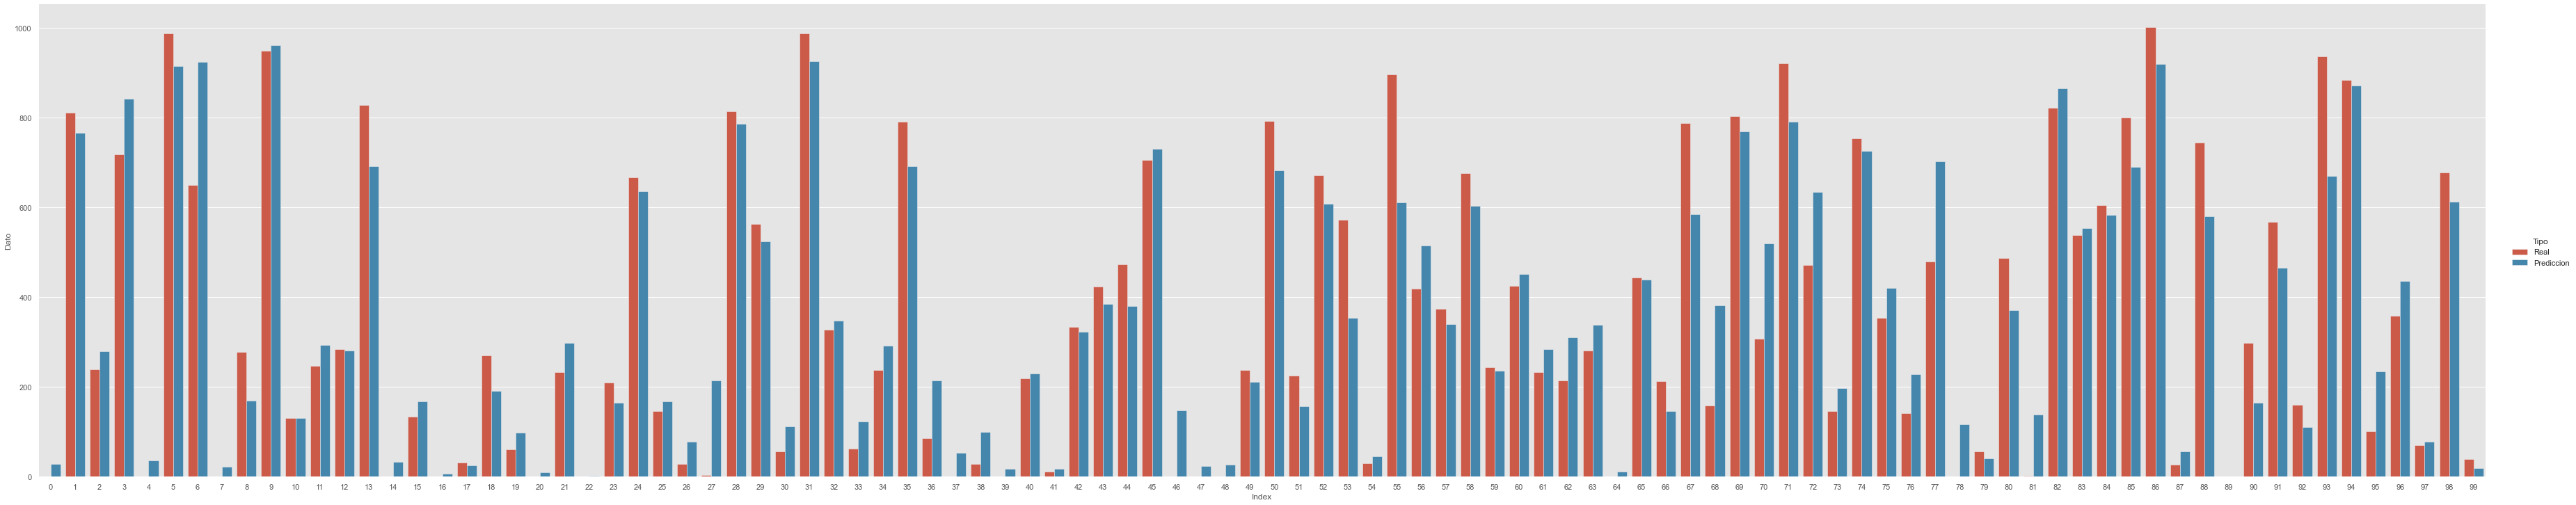

In [82]:
graf_compara('Random forest model', list(y_test[columnas_objetivo[0]])[:100], pred_forest[:100])

Prediction values and overall trend of target values are visually compared

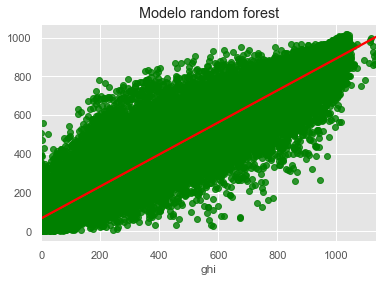

In [83]:
sns.regplot(x = y_test, y = pred_forest,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Random forest model');

The metrics are obtained from the model results

In [84]:
metricas_forest = metricas('Random forest model', y_test, pred_forest)

MODEL:  Modelo de random forest
MAE:  78.56661858357327
MSE:  109.73118507210256
RMSE:  109.73118507210256
R2 :  0.8832950180604224


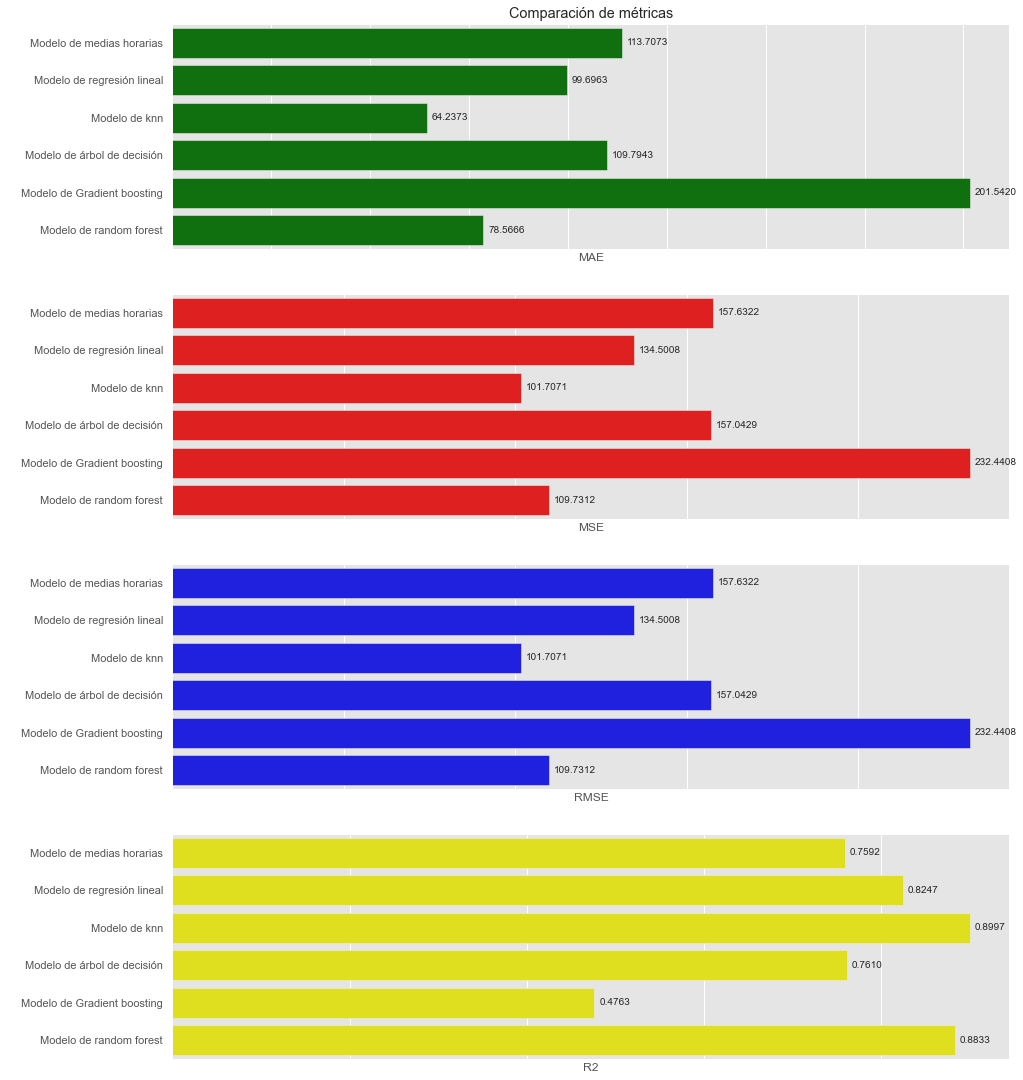

In [85]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest])

# Check for overfitting

A solution to find out if a model suffers from "overfitting" is a procedure called cross validation (CV). In the basic approach, called k-fold CV, the training set is divided into k smaller sets. The following procedure is followed for each of the k "folds":

- A model is trained using ``k-1`` of the folds as training data;

- The resulting model is validated on the remaining part of the data (that is, it is used as a set of tests to calculate a performance measure such as precision)

It is recommended that the number of folds f be calculated as: ``m / f> n ^ 2``  where m x n is the dimensions of the data set

In [69]:
x.shape

(252112, 75)

In [70]:
f = (x.shape[0]/(x.shape[1])**2)/5
f

8.963982222222223

In [71]:
scalar_sobredimension = StandardScaler()
pca_sobredimension = PCA(n_components = 62)
model = knn

pipeline = Pipeline([('transformer', scalar_sobredimension), ('pca', pca_sobredimension), ('estimator', model)])

scores = cross_val_score(pipeline, x, y.values.ravel(), cv = int(f), scoring = 'r2')
scores_numerico = []
[scores_numerico.append(float(i)) for i in list(scores)]
print(scores_numerico)
print("The mean value of R² is {}, with a standard deviation of {}".format(np.mean(scores_numerico), np.std(scores_numerico)))

[0.52472271824531, 0.444719256876421, 0.6735128217730393, 0.643680711177969, 0.6299864242211831, 0.6403610184788344, 0.7255400488160635, 0.5884247393022517]
The mean value of R² is 0.608868467361384, with a standard deviation of 0.08282829233412355


The best model trained so far is that of k-Nearest Neighbors. It can be seen that it is over-tuned so an attempt will be made to find a better one

# GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

GridSearchCV is a class available in scikit-learn that allows you to systematically evaluate and select the parameters of a model. By indicating a model and the parameters to test, you can evaluate the performance of the former based on the latter through cross-validation. This function helps you step through predefined hyperparameters and fit your estimator (model) in your training set.

Therefore, it will be applied to the previously tested models, with r² as the metric

# Linear Regression with GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# The model is created and trained
regre_grid = GridSearchCV(LinearRegression(),
                       param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]},
                       cv = 2,
                       scoring = "r2")

regre_grid.fit(x_train,y_train)

# The prediction is obtained
pred_reg_grid_ = regre_grid.predict(x_test)

# Chosen parameters
regre_grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [92]:
pred_reg_grid = []
[pred_reg_grid.append(y[0]) for y in pred_reg_grid_.tolist()]
pred_reg_grid[:1000]

[120.9204420561673,
 880.0341008903486,
 350.15504223877315,
 867.8730976437756,
 51.10043920958924,
 929.3564673064687,
 1065.2589901831564,
 19.631849321059292,
 131.23675132064974,
 967.0044268926739,
 5.316633910044175,
 387.9529726923399,
 305.72508098172125,
 713.0228222656252,
 112.63841753821708,
 200.18336250837177,
 49.50258521329897,
 16.61454691973779,
 198.13532260030843,
 115.1010979405279,
 144.58839775258429,
 260.93803676667835,
 36.93968508419192,
 149.30504067145893,
 547.9845625972664,
 204.17265868807047,
 20.5874995301715,
 79.81790068062048,
 736.6088683505857,
 842.6514933376181,
 140.23481404483306,
 951.5416916517253,
 516.4484385434129,
 248.2610671671376,
 186.1162659683,
 673.0897280905588,
 135.39407531178475,
 216.17865488847917,
 85.29727316054823,
 42.491971318303456,
 260.5590570239701,
 14.989471921467725,
 476.88715658126677,
 417.24970792655034,
 424.3944249538898,
 728.5688007627549,
 89.64927951389478,
 43.46200998642604,
 -9.56550594698598,
 184.

Some example prediction values are visually compared

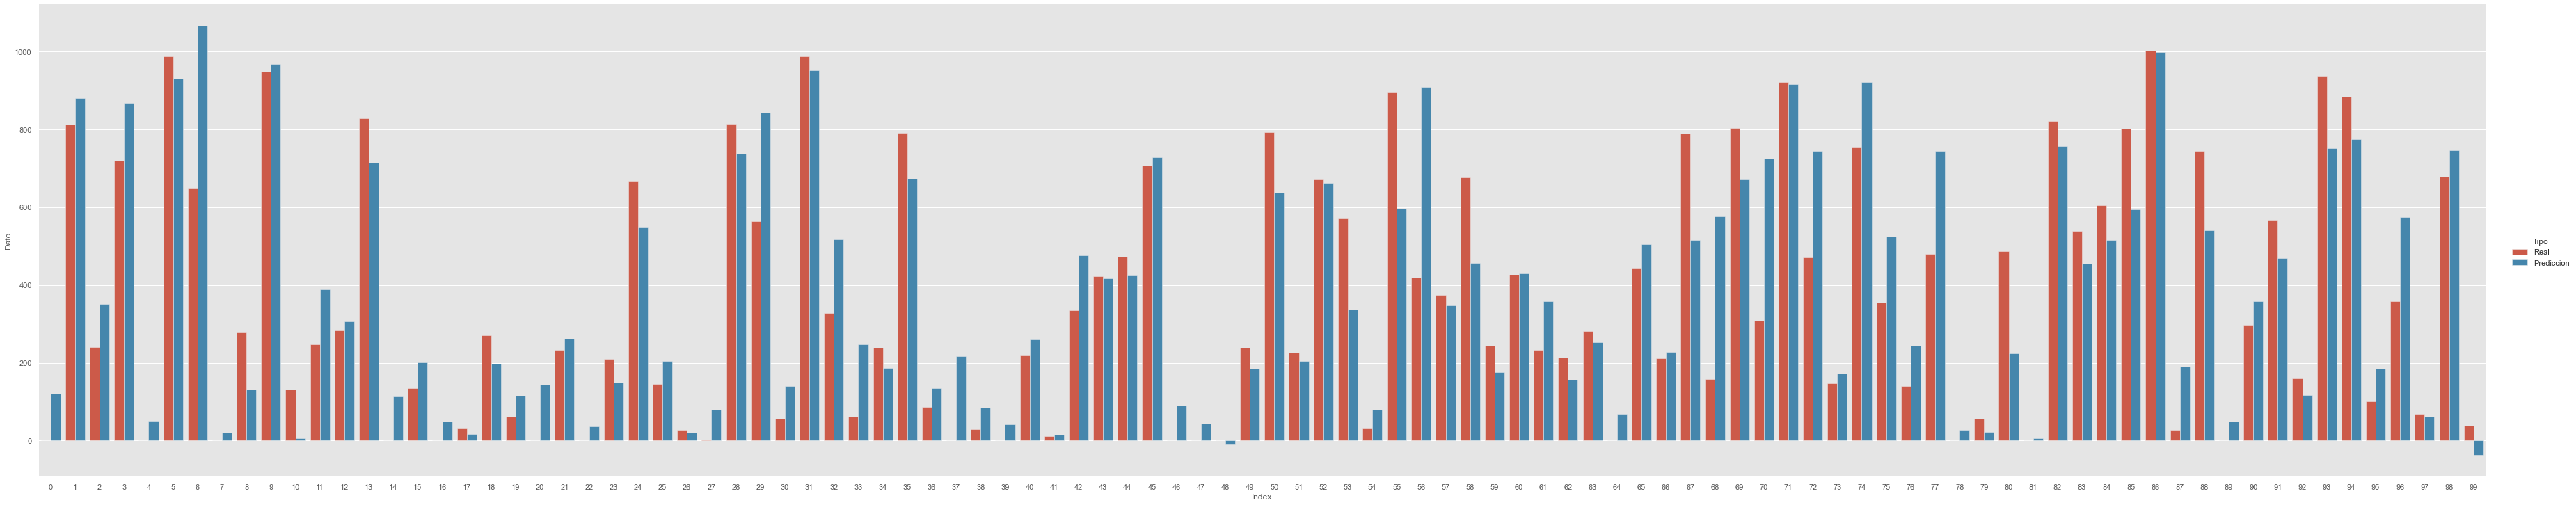

In [93]:
graf_compara('Linear Regression Model with GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_reg_grid[:100])

Prediction values and overall trend of target values are visually compared

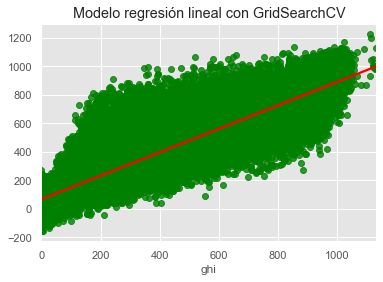

In [94]:
sns.regplot(x = y_test, y = pred_reg_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Linear Regression Model with GridSearchCV');

The metrics are obtained from the model results

In [95]:
metricas_reg_grid = metricas('Linear Regression Model with GridSearchCV', y_test, pred_reg_grid)

MODEL:  Modelo de regresión lineal con GridSearchCV
MAE:  99.69632559912247
MSE:  134.50080247520484
RMSE:  134.50080247520484
R2 :  0.8246608052548182


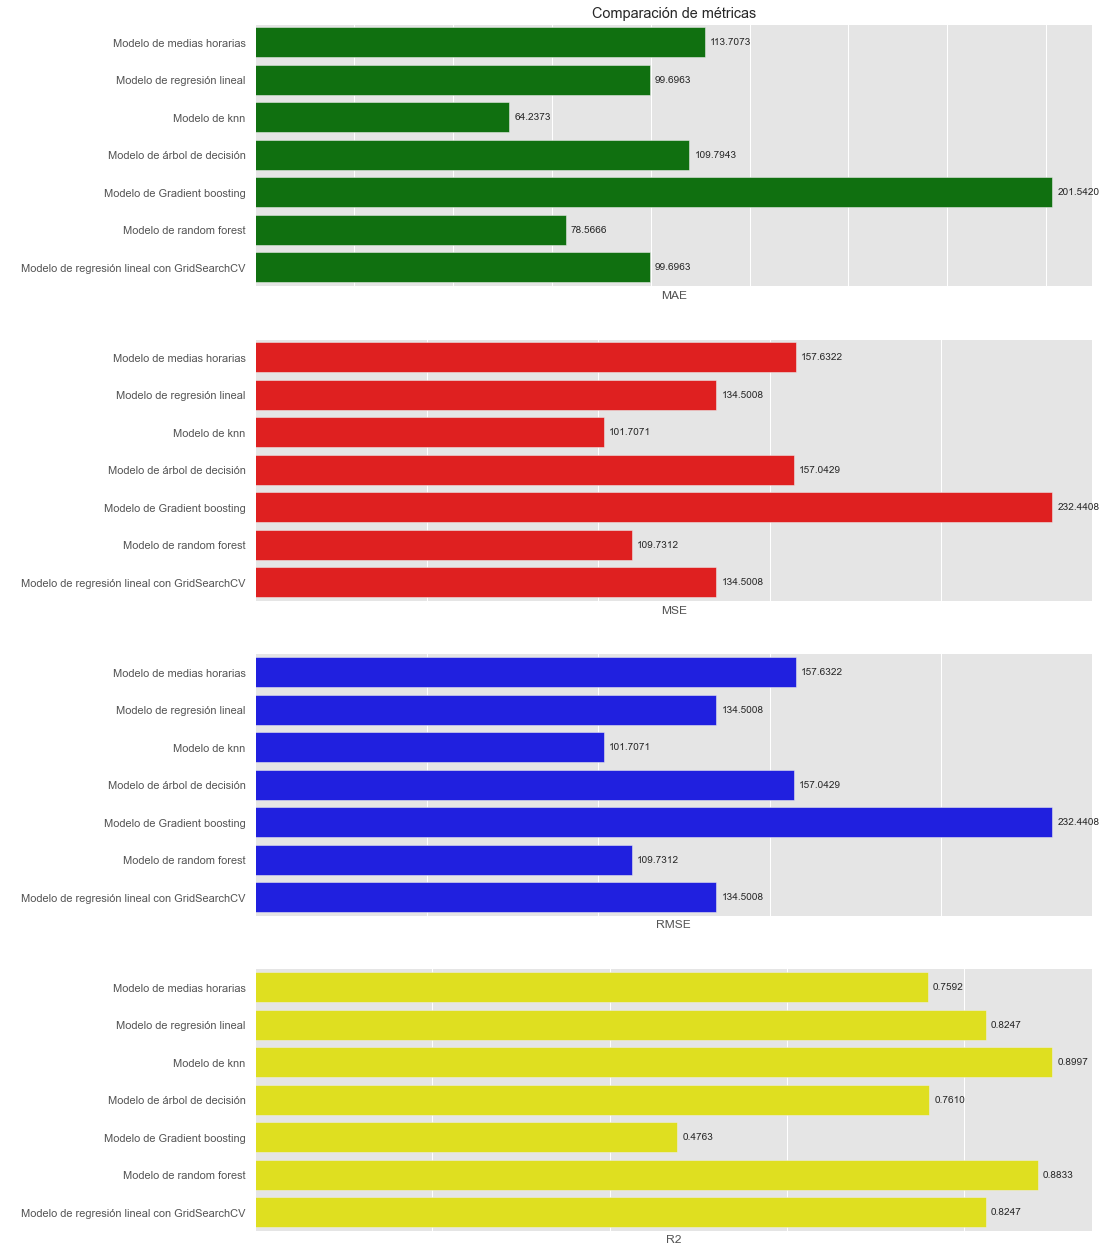

In [96]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid])

# k-Nearest Neighbors with GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# The model is created and trained
knn_grid = GridSearchCV(KNeighborsRegressor(),
                       param_grid = {"n_neighbors":np.arange(1, 6),
                                     "leaf_size":np.arange(10, 30)},
                       cv = 2,
                       scoring = "r2")


knn_grid.fit(x_train, y_train)

# The prediction is obtained
pred_knn_grid_ = knn_grid.predict(x_test)

# Chosen parameters
knn_grid.best_params_

{'leaf_size': 10, 'n_neighbors': 3}

In [100]:
pred_knn_grid = []
[pred_knn_grid.append(y[0]) for y in pred_knn_grid_.tolist()]
pred_knn_grid[:1000]

[12.591099999999999,
 698.3321333333333,
 204.417,
 640.0728,
 1.8685,
 991.4610666666667,
 797.8672,
 0.0,
 182.2117333333333,
 907.4606,
 211.31256666666664,
 336.00530000000003,
 428.11923333333334,
 816.1139,
 29.4091,
 124.1635,
 0.0,
 43.929966666666665,
 273.4348333333333,
 21.67983333333333,
 0.0,
 307.02823333333333,
 0.0,
 109.88166666666666,
 521.3453999999999,
 80.85156666666667,
 16.984266666666667,
 173.4620666666667,
 892.3092333333334,
 366.3188333333333,
 38.21546666666667,
 967.6785,
 307.19146666666666,
 89.2396,
 134.72636666666668,
 735.1486000000001,
 96.68740000000001,
 29.68856666666667,
 159.02073333333334,
 5.333033333333334,
 221.15443333333334,
 36.5101,
 244.59759999999997,
 578.3071333333334,
 397.42856666666665,
 874.7863333333333,
 9.150733333333333,
 55.674566666666664,
 43.03156666666667,
 245.61053333333334,
 900.1585333333334,
 407.5100333333333,
 959.3217333333332,
 201.7237,
 42.15846666666667,
 916.6252333333333,
 398.50056666666666,
 424.85013333

Some example prediction values are visually compared

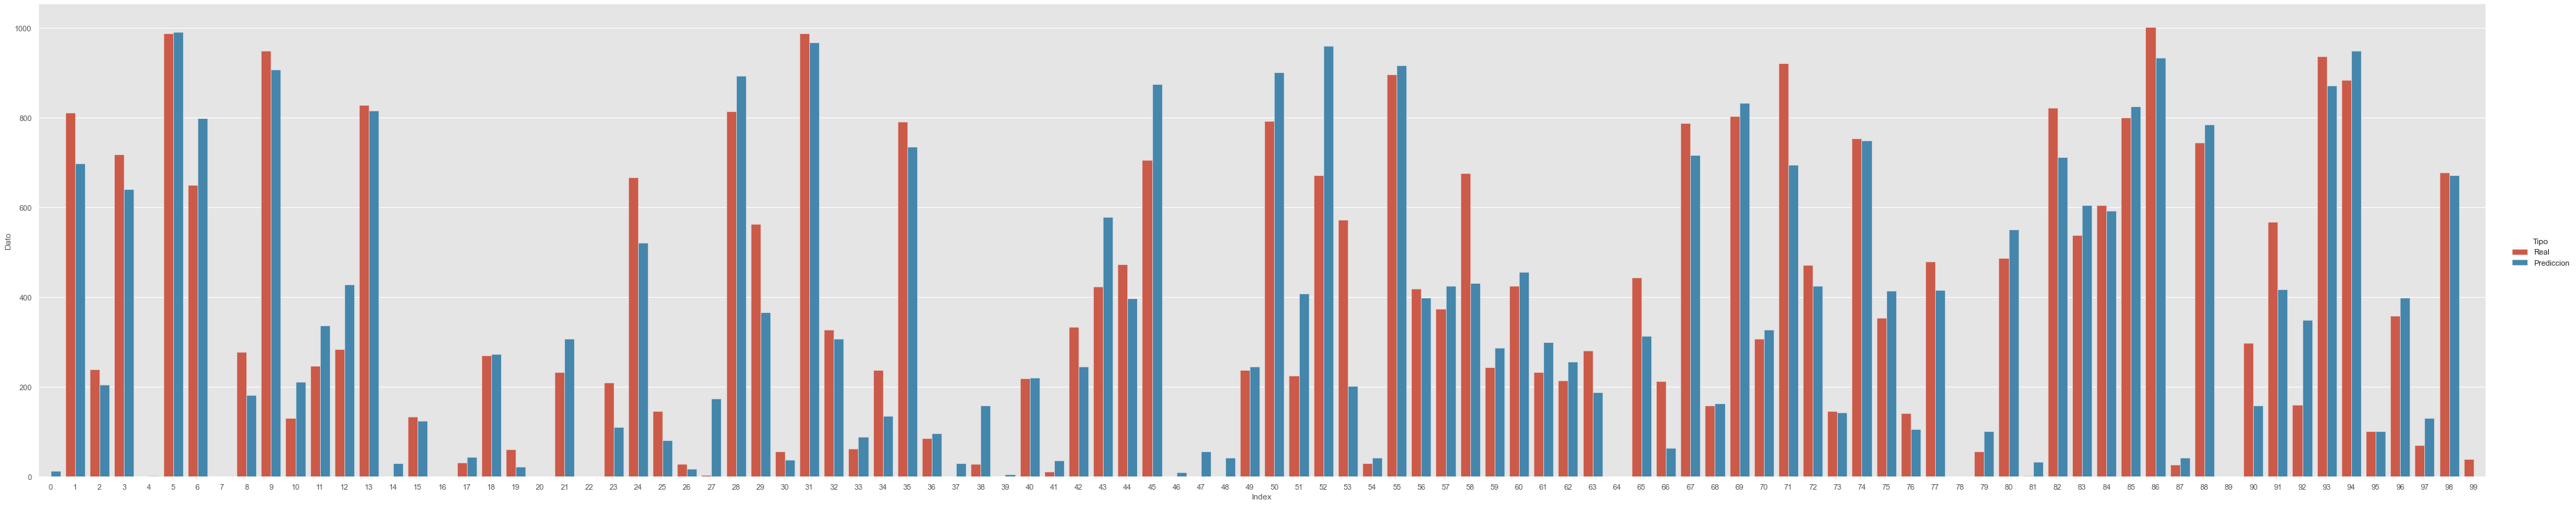

In [101]:
graf_compara('Knn model with GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_knn_grid[:100])

Prediction values and overall trend of target values are visually compared

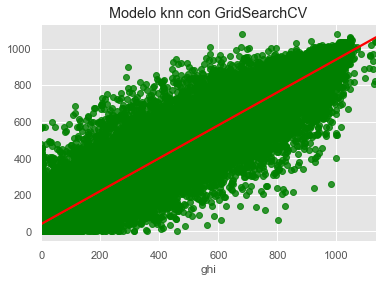

In [102]:
sns.regplot(x = y_test, y = pred_knn_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Knn model with GridSearchCV');

The metrics are obtained from the model results

In [103]:
metricas_knn_grid = metricas('Knn model with GridSearchCV', y_test, pred_knn_grid)

MODEL:  Modelo de knn con GridSearchCV
MAE:  68.28434262873148
MSE:  101.90086768824511
RMSE:  101.90086768824511
R2 :  0.8993566646872866


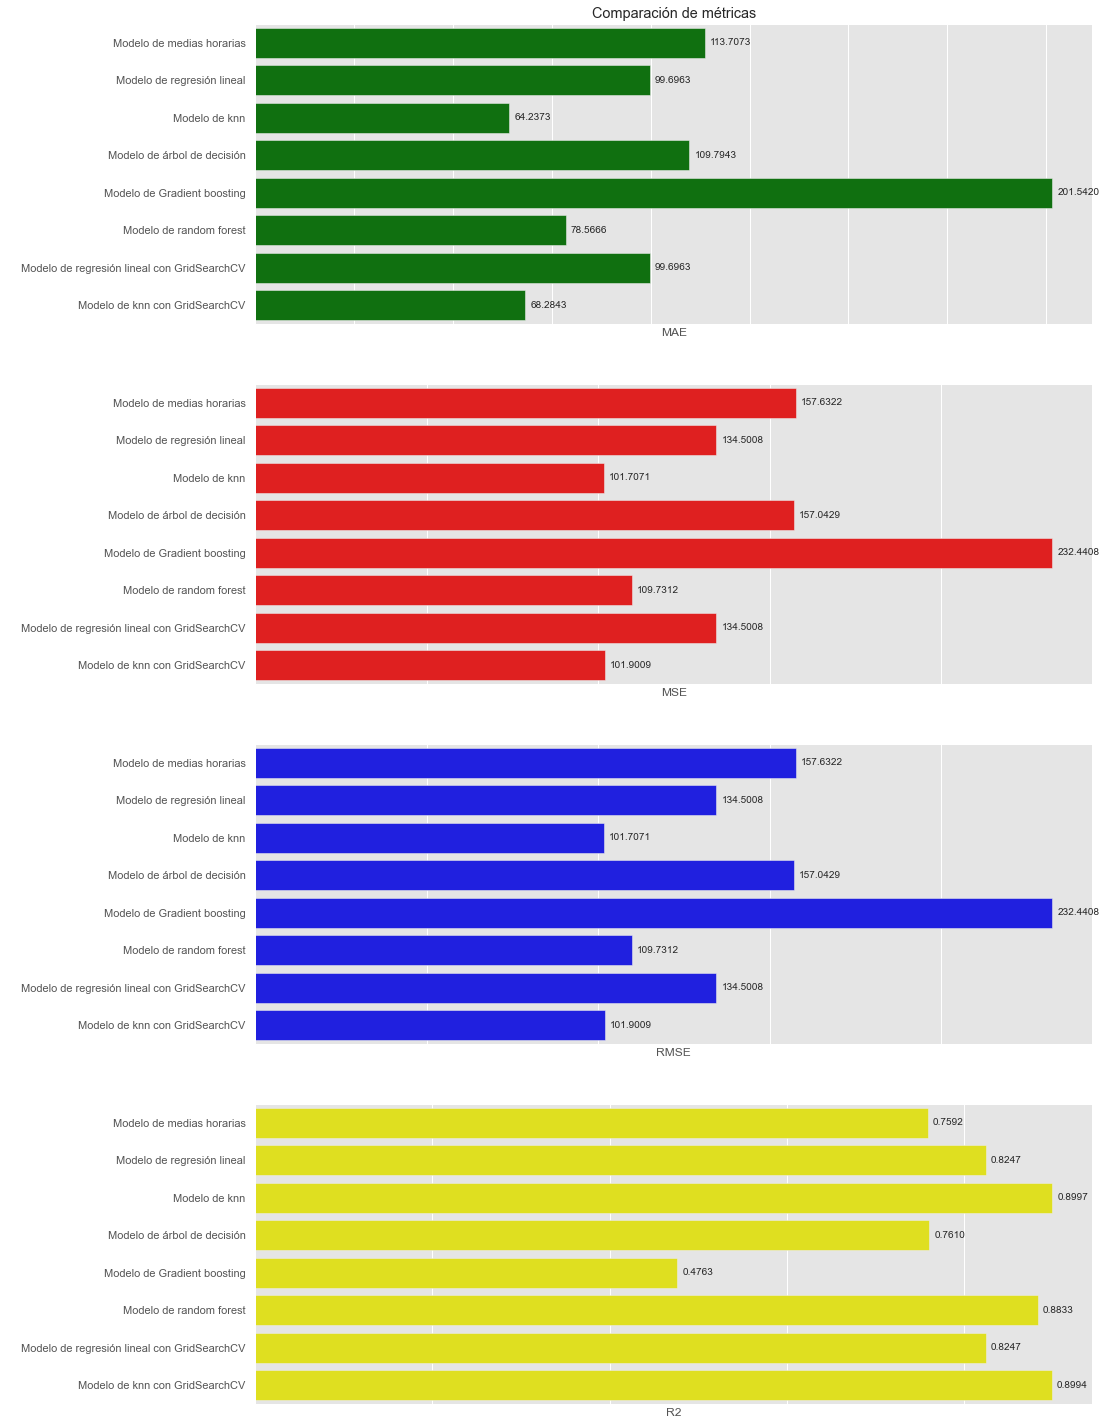

In [104]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid])

# Decision tree with GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# The model is created and trained
tree_grid = GridSearchCV(DecisionTreeRegressor(),
                       param_grid = {"max_depth":np.arange(25,35),
                                     "min_samples_leaf":np.arange(2,10)},
                       cv = 2,
                       scoring = "r2")

tree_grid.fit(x_train,y_train)

# The prediction is obtained
pred_tree_grid_ = tree_grid.predict(x_test)

# Chosen parameters
tree_grid.best_params_

{'max_depth': 29, 'min_samples_leaf': 9}

In [108]:
pred_tree_grid = []
[pred_tree_grid.append(y) for y in pred_tree_grid_.tolist()]
pred_tree_grid[:1000]

[0.0,
 670.2019785714284,
 331.35730714285717,
 847.3667727272727,
 9.292658333333334,
 909.4421928571428,
 974.5310111111111,
 0.0,
 47.63264,
 964.6688999999999,
 206.39710833333334,
 273.6553923076923,
 218.11964444444448,
 783.9140555555556,
 33.51727777777778,
 57.92568333333333,
 0.1607333333333333,
 5.725088888888889,
 219.12761,
 57.73432,
 0.0,
 240.16945384615386,
 0.0,
 95.31403333333333,
 364.77900000000005,
 106.11580000000001,
 54.92388888888889,
 144.31909090909093,
 840.6917785714285,
 750.7063555555555,
 117.07036000000001,
 996.4674928571427,
 407.20091,
 104.3628,
 133.09265555555555,
 768.3456166666666,
 151.20458461538462,
 45.70649999999999,
 25.970466666666667,
 0.0,
 228.5748,
 0.6385799999999999,
 346.93033,
 296.9082,
 394.34504375000006,
 660.6677777777778,
 36.0923,
 0.2806222222222223,
 0.004825,
 52.071299999999994,
 777.0224384615384,
 58.39705882352943,
 812.252282352941,
 306.6914933333333,
 172.69263333333333,
 566.42256875,
 435.6395636363637,
 422.33

Some example prediction values are visually compared

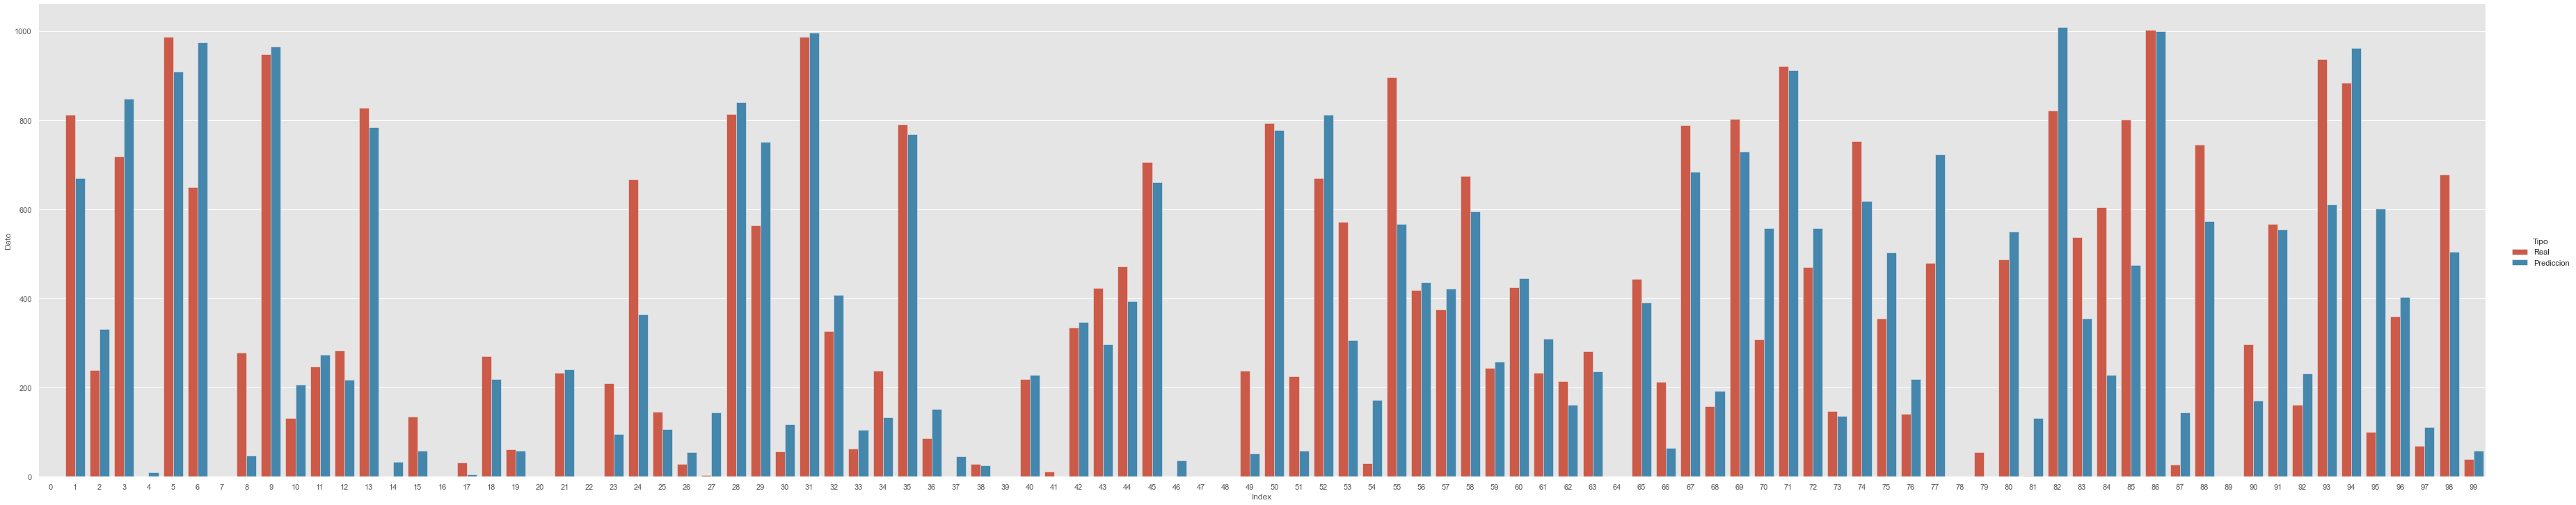

In [109]:
graf_compara('Decision tree model with GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_tree_grid[:100])

Prediction values and overall trend of target values are visually compared

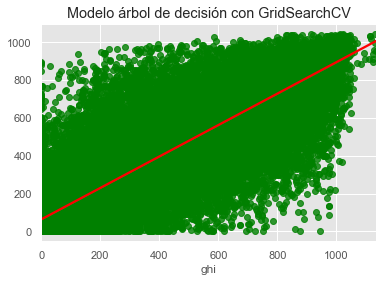

In [110]:
sns.regplot(x = y_test, y = pred_tree_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Decision tree model with GridSearchCV');

The metrics are obtained from the model results

In [111]:
metricas_tree_grid = metricas('Decision tree model with GridSearchCV', y_test, pred_tree_grid)

MODEL:  Modelo de árbol de decisión con GridSearchCV
MAE:  108.325903733692
MSE:  159.14765185548615
RMSE:  159.14765185548615
R2 :  0.7545123055546992


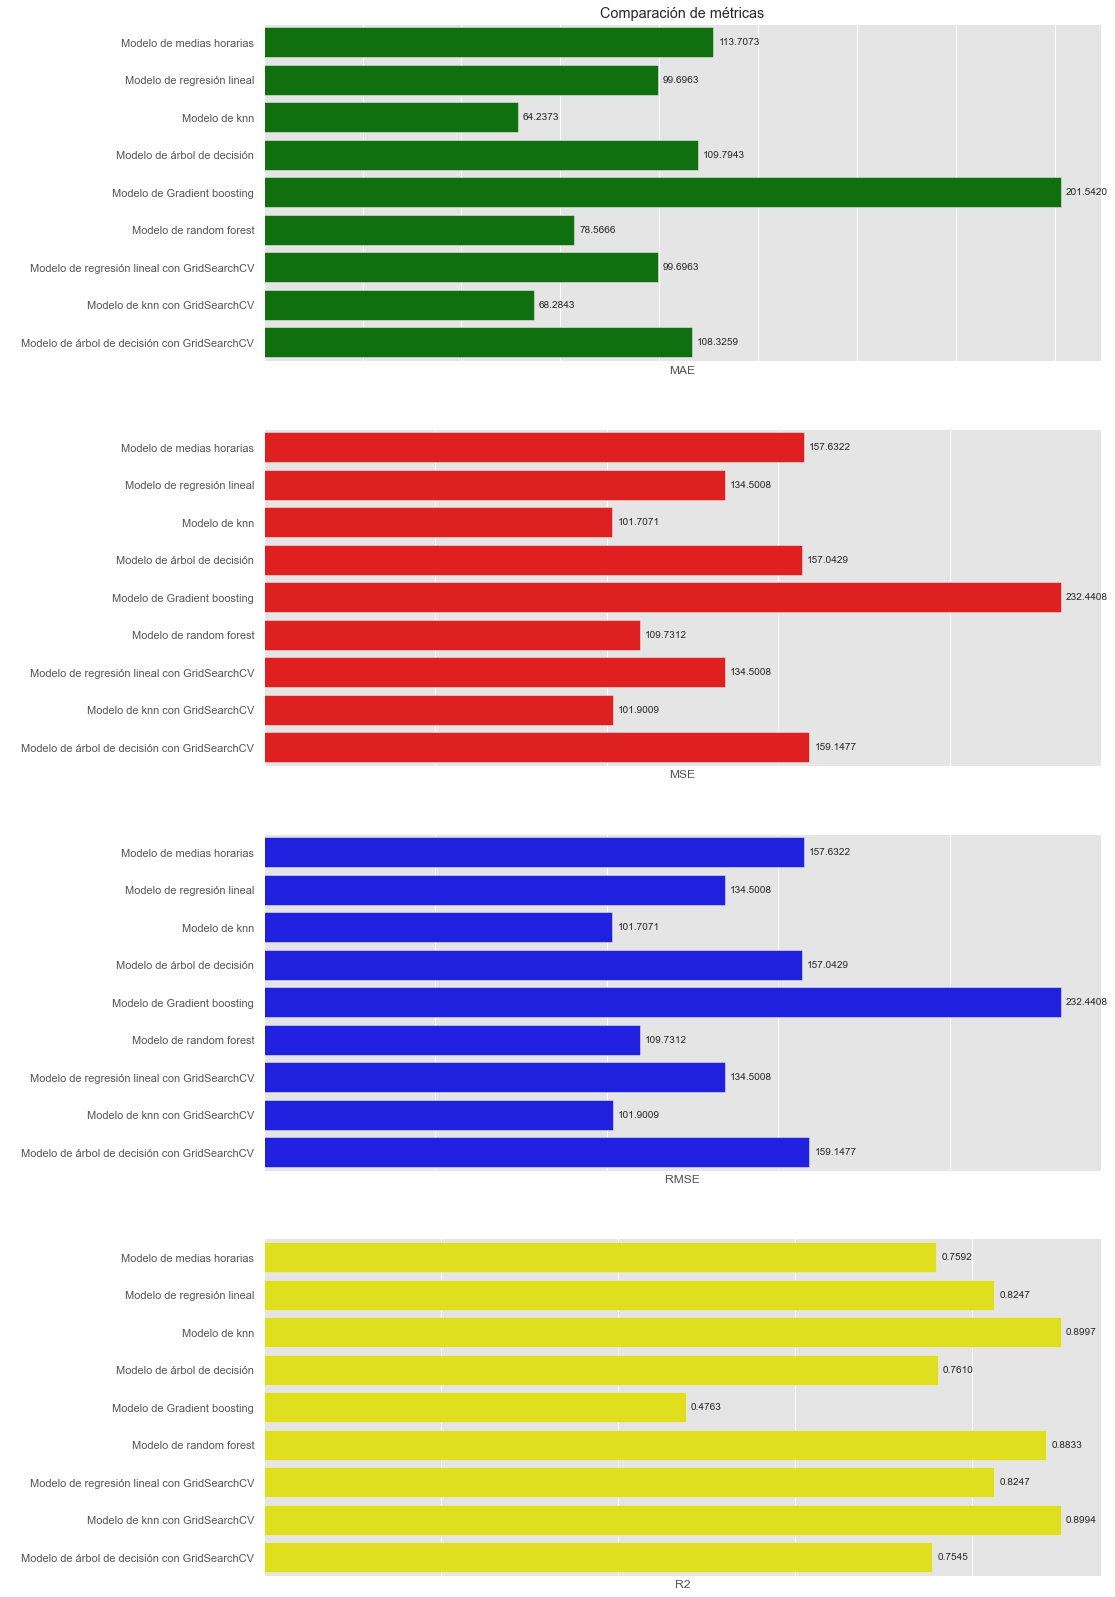

In [112]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid])

# Gradient boosting with GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# The model is created and trained
# n_jobs: -1 means using all processors

gbm_grid =  GridSearchCV(GradientBoostingRegressor(),
                       param_grid = {'n_estimators':[100,500], 
                                'learning_rate': [0.1,0.05,0.02],
                                'max_depth':[4], 
                                'min_samples_leaf':[3], 
                                'max_features':[1.0] },
                       cv = 2,
                       scoring = "neg_mean_absolute_error")
                            
gbm_grid.fit(x_train,y_train.values.ravel())

# The prediction is obtained
pred_gbm_grid_ = gbm_grid.predict(x_test)

# Chosen parameters
gbm_grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 1.0,
 'min_samples_leaf': 3,
 'n_estimators': 500}

In [116]:
pred_gbm_grid = []
[pred_gbm_grid.append(y) for y in pred_gbm_grid_.tolist()]
pred_gbm_grid[:1000]

[-34.32066091793597,
 761.8448976510965,
 325.9306841585271,
 873.0248572825845,
 -11.517832028444605,
 959.5424475080814,
 964.9471555133352,
 -1.3715497645954156,
 156.25162422176444,
 966.8782363897814,
 74.84149478355248,
 425.2759638862242,
 267.8417403660118,
 705.6459536508263,
 89.34494541916526,
 212.95922319127095,
 34.95964472847518,
 87.2945183965389,
 179.22649413160528,
 87.55215082681352,
 104.59307275887583,
 204.8729402544856,
 13.145778493276248,
 134.32627715278,
 586.946778416254,
 175.96173879957118,
 61.13952709806875,
 83.23151437325319,
 814.461374582441,
 558.1813601145495,
 128.78471243401827,
 927.1256991242283,
 487.7004297799871,
 292.01050712142484,
 176.73249163704088,
 677.5290562712386,
 82.60011495198131,
 161.67032855738677,
 84.81738956242175,
 1.2420268392662193,
 279.70689120336607,
 -74.0804039706669,
 446.329474103265,
 394.99921561516794,
 385.0895975651327,
 744.2961687370057,
 148.89060654691812,
 25.777898300803372,
 -24.678105274984166,
 139

Some example prediction values are visually compared

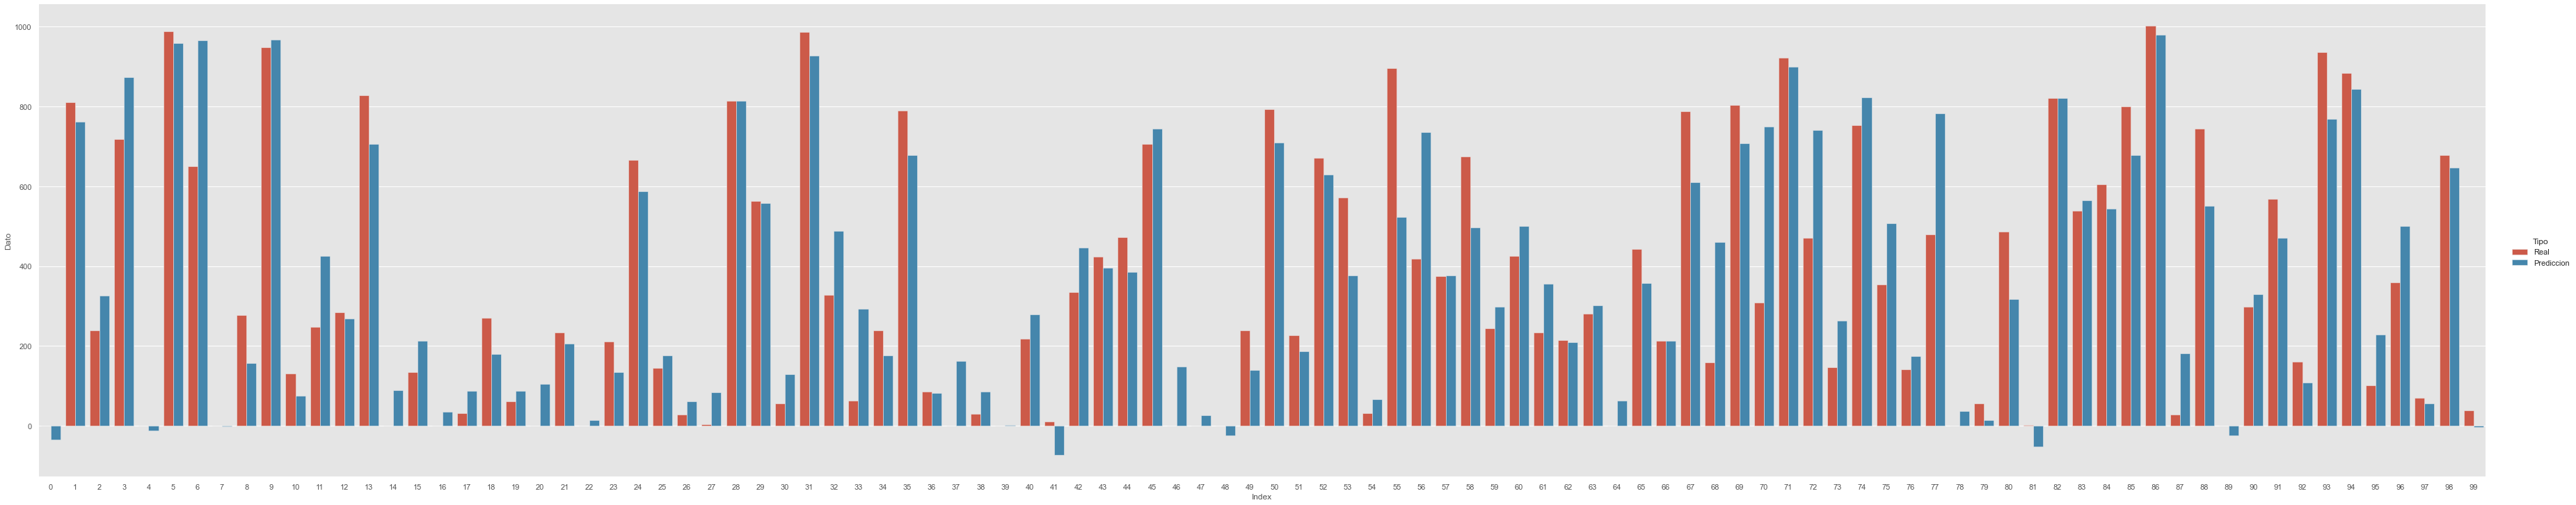

In [117]:
graf_compara('Gradient boosting model with GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_gbm_grid[:100])

Prediction values and overall trend of target values are visually compared

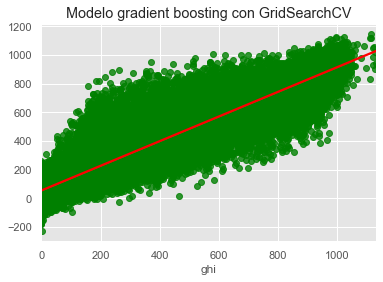

In [118]:
sns.regplot(x = y_test, y = pred_gbm_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Gradient boosting model with GridSearchCV');

The metrics are obtained from the model results

In [119]:
metricas_gbm_grid = metricas('Gradient boosting model with GridSearchCV', y_test, pred_gbm_grid)

MODEL:  Modelo de gradient boosting con GridSearchCV
MAE:  86.02011212051889
MSE:  118.04450254882089
RMSE:  118.04450254882089
R2 :  0.864941852210195


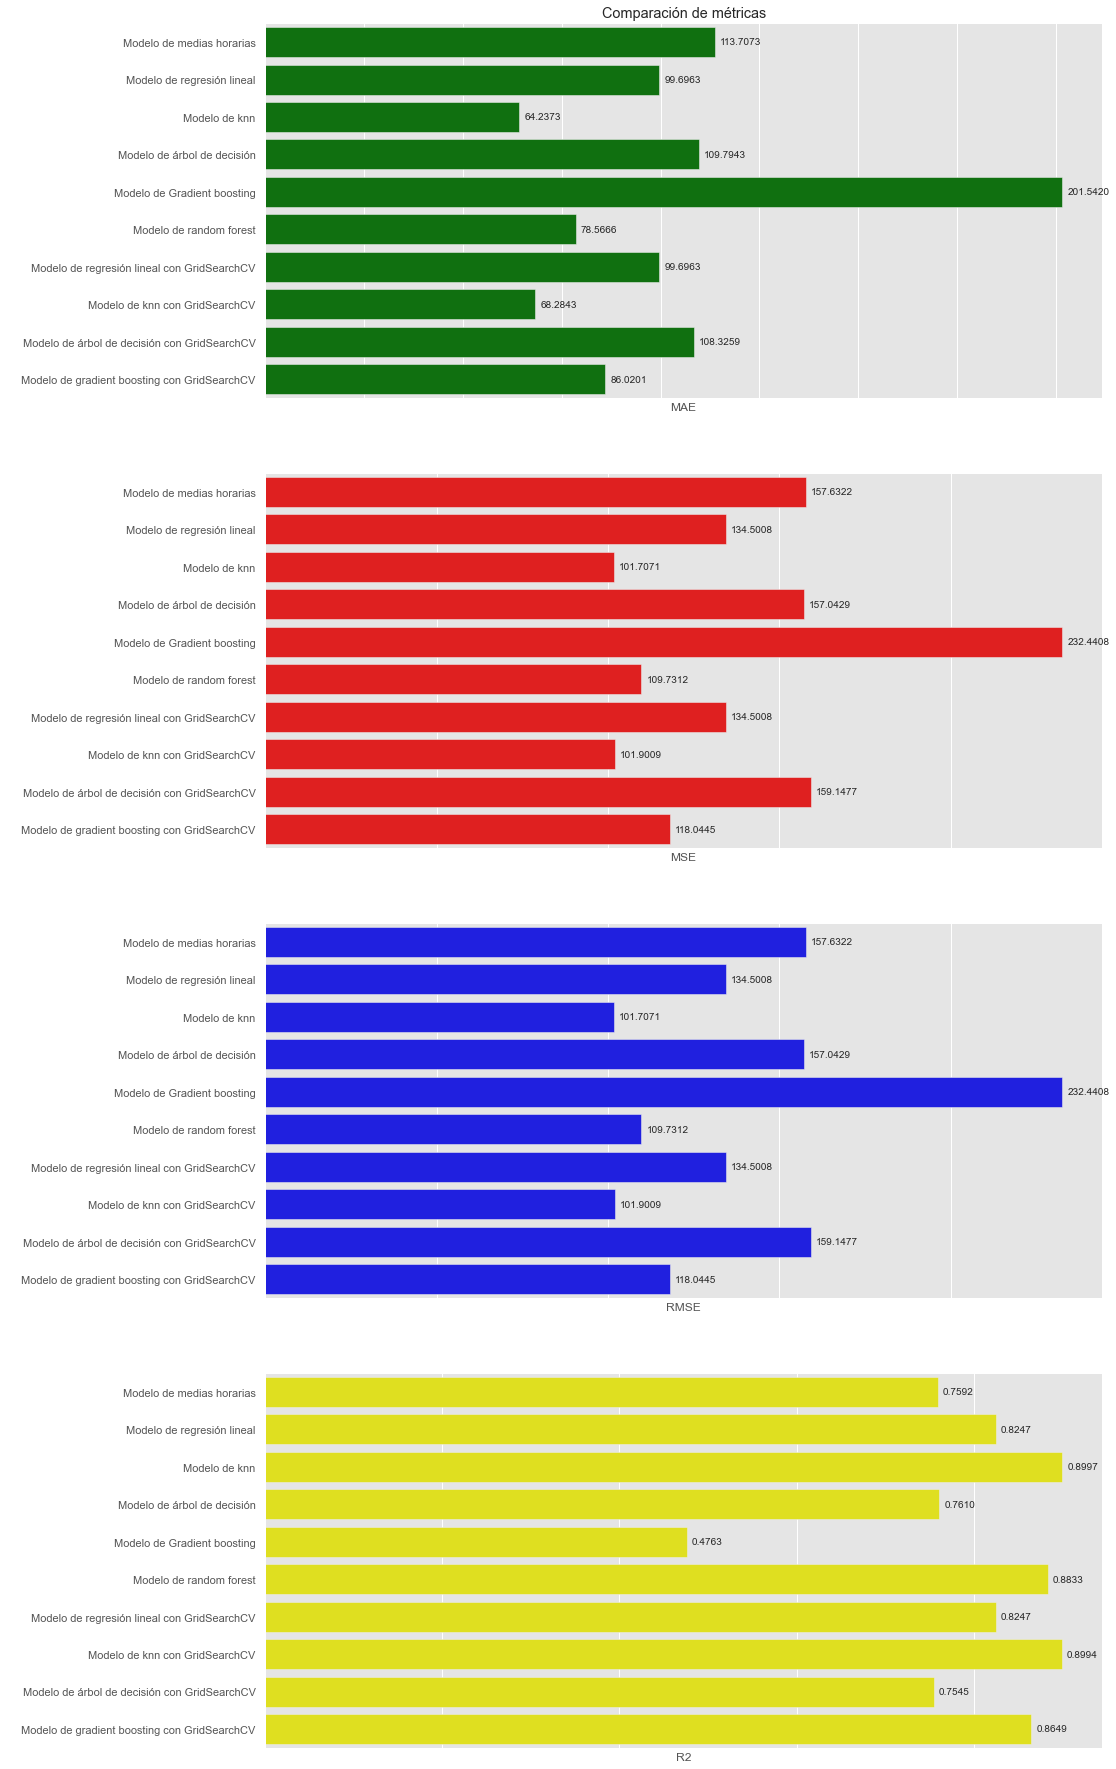

In [120]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid,
                    metricas_gbm_grid])

# Random forest with Regressor RandomizedSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

RandomizedSearchCV implements a "fit" and "score" method. The estimator parameters used to apply these methods are optimized by a cross-validation search on the parameter settings. Unlike GridSearchCV, not all parameter values are tested, but rather a fixed number of parameter settings are sampled from the specified distributions. The number of parameter settings that are tested is given by n_iter

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# The model is created and trained

forest_random = RandomizedSearchCV(RandomForestRegressor(),
                       param_distributions={"max_depth":np.arange(25,35),
                                  "min_samples_leaf":np.arange(2,10),
                                  "n_estimators": (10,50,100,500)},
                       cv = 2,
                       scoring = "r2",
                       n_iter = 5)
                            
forest_random.fit(x_train,y_train.values.ravel())

# The prediction is obtained
pred_forest_random_ = forest_random.predict(x_test)

# Chosen parameters
forest_random.best_params_

{'n_estimators': 500, 'min_samples_leaf': 3, 'max_depth': 34}

In [124]:
pred_forest_random = []
[pred_forest_random.append(y) for y in pred_forest_random_.tolist()]
pred_forest_random[:1000]

[28.117304173650925,
 743.987721421762,
 312.6439052875247,
 824.4174427683187,
 28.972055339359834,
 909.5743100552796,
 924.283683926117,
 8.295164031280297,
 168.2349222446753,
 947.0278663764041,
 130.66429222450216,
 297.2844224320634,
 294.58155758535895,
 663.1351776519983,
 34.16741762832476,
 182.9889487622817,
 7.114569427649889,
 22.50404888905926,
 189.3668199979142,
 96.67765365411029,
 14.056875962405636,
 295.30015299462707,
 6.426196882517638,
 178.7114503802849,
 645.5063003782244,
 183.54235563151963,
 73.36061210730989,
 190.3488249715567,
 797.4554127936664,
 550.0597453659518,
 119.1548123745233,
 920.675402362927,
 347.5747337535991,
 111.47827582692756,
 313.4196739322118,
 681.627165172513,
 214.23491140878,
 57.79315214517196,
 116.52036393124102,
 8.75444969722242,
 227.7953375356211,
 16.78031661729167,
 326.303756154378,
 367.49242854334346,
 381.5112097744904,
 745.9477653809596,
 150.60677903655167,
 24.492385263023102,
 20.217135327231095,
 213.4930626438

Some example prediction values are visually compared

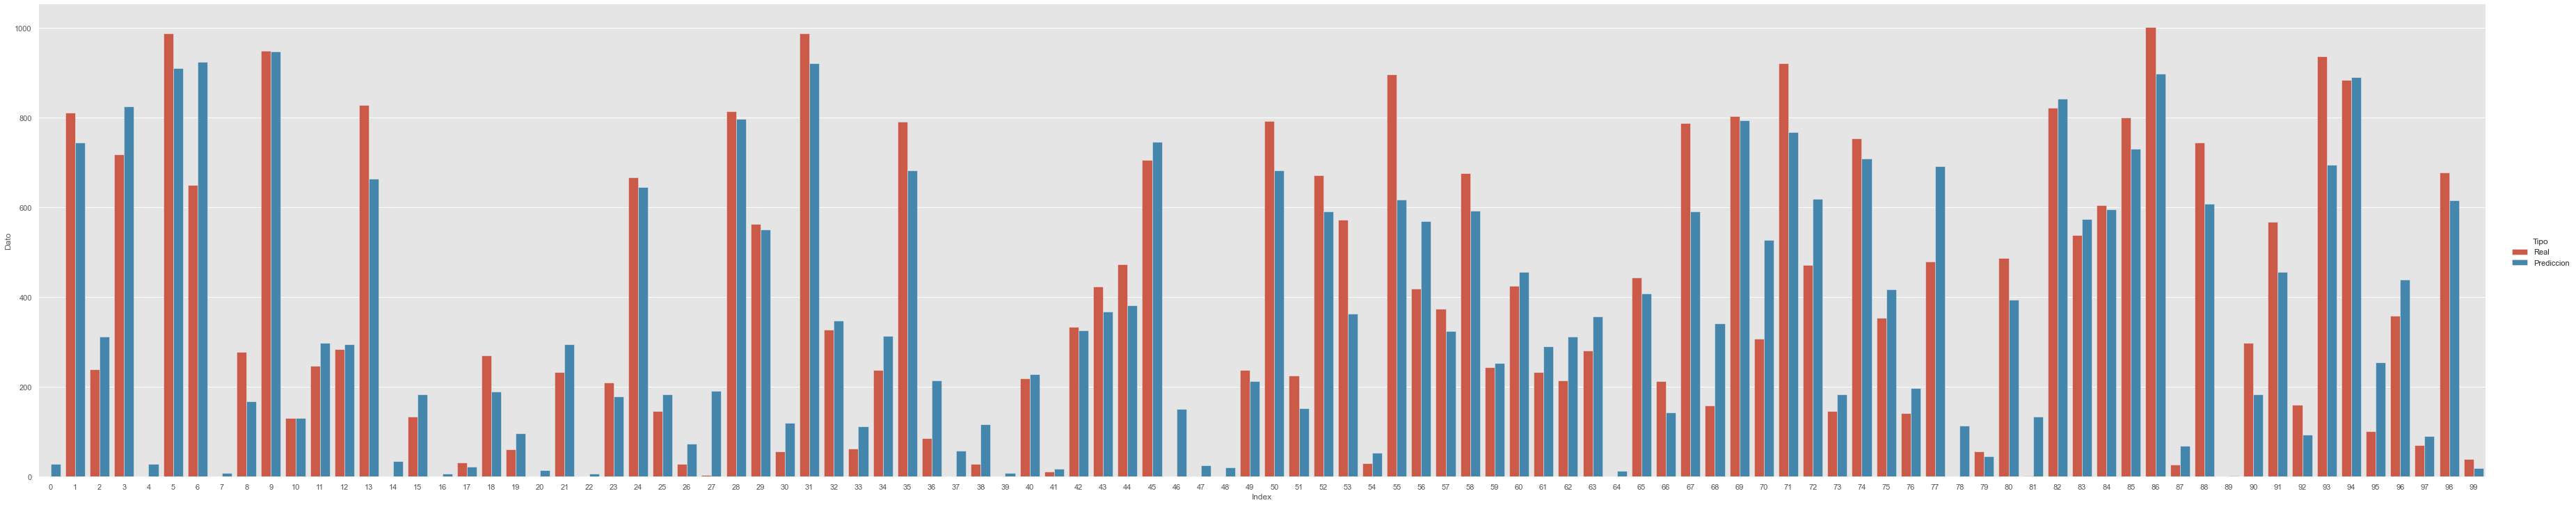

In [125]:
graf_compara('Random forest model with RandomizedSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_forest_random[:100])

Prediction values and overall trend of target values are visually compared

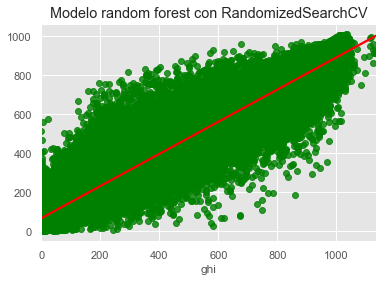

In [126]:
sns.regplot(x = y_test, y = pred_forest_random,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Random forest model with RandomizedSearchCV');

The metrics are obtained from the model results

In [127]:
metricas_forest_random = metricas('Random forest model with RandomizedSearchCV', y_test, pred_forest_random)

MODEL:  Modelo de random forest con RandomizedSearchCV
MAE:  79.11838444586404
MSE:  110.09541858795157
RMSE:  110.09541858795157
R2 :  0.8825189685794729


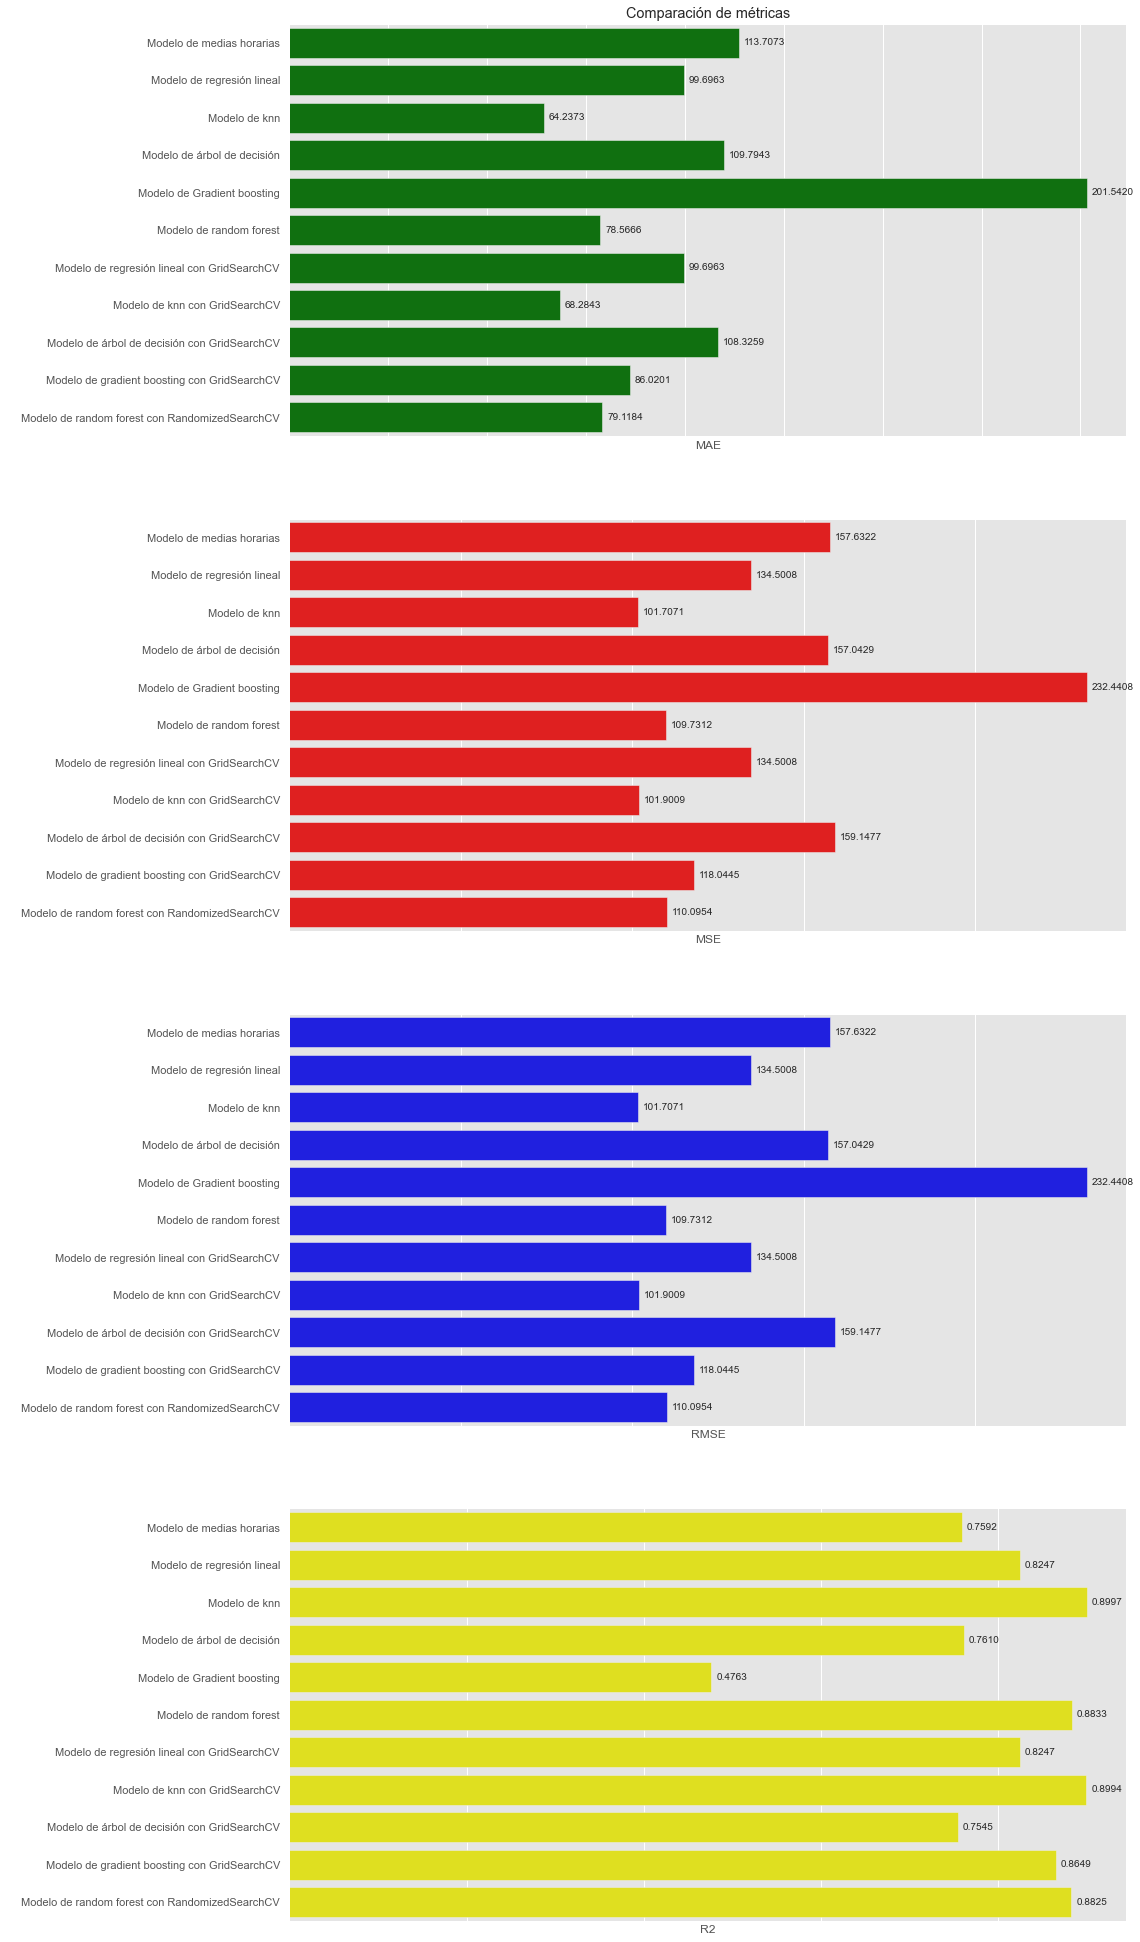

In [128]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid,
                    metricas_gbm_grid,
                    metricas_forest_random])

# Tensorflow

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

TensorFlow is Google Brain's second-generation machine learning system, released as open source software on November 9, 2015. TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive and flexible ecosystem of tools, libraries and community resources that enables researchers to innovate with machine learning and developers to easily compile and deploy applications with machine learning technology

In [131]:
#! pip install --upgrade tensorflow

In [132]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

# The model is created and trained

input_layer = Input(shape = (x_train_pca.shape[1],))
dense_layer_1 = Dense(100, activation = 'relu')(input_layer)
dense_layer_2 = Dense(50, activation = 'relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation = 'relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

tensor = Model(inputs = input_layer, outputs = output)
tensor.compile(loss = "mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error"])

tensor.fit(x_train, y_train.values.ravel(), batch_size = 2, epochs = 100, verbose = 1, validation_split = 0.2)

# The prediction is obtained
pred_tensor_ = tensor.predict(x_test)

Epoch 1/100
43761/43761 [==============================] - 399s 9ms/step - loss: 16559.9160 - mean_squared_error: 16559.9160 - val_loss: 13891.7764 - val_mean_squared_error: 13891.7764
Epoch 2/100
43761/43761 [==============================] - 355s 8ms/step - loss: 12510.2451 - mean_squared_error: 12510.2451 - val_loss: 11924.2373 - val_mean_squared_error: 11924.2373
Epoch 3/100
43761/43761 [==============================] - 273s 6ms/step - loss: 11088.7139 - mean_squared_error: 11088.7139 - val_loss: 11554.6680 - val_mean_squared_error: 11554.6680
Epoch 4/100
43761/43761 [==============================] - 328s 7ms/step - loss: 10213.7666 - mean_squared_error: 10213.7666 - val_loss: 10157.0420 - val_mean_squared_error: 10157.0420
Epoch 5/100
43761/43761 [==============================] - 350s 8ms/step - loss: 9583.7002 - mean_squared_error: 9583.7002 - val_loss: 9677.8770 - val_mean_squared_error: 9677.8770
Epoch 6/100
43761/43761 [==============================] - 363s 8ms/step - loss

In [133]:
pred_tensor = []
[pred_tensor.append(y[0]) for y in pred_tensor_.tolist()]
pred_tensor[:1000]

[-22.081836700439453,
 871.7131958007812,
 295.3314514160156,
 902.3330078125,
 0.9114894866943359,
 966.9814453125,
 1004.2357788085938,
 -8.865768432617188,
 148.13766479492188,
 943.7850341796875,
 89.7457275390625,
 168.88558959960938,
 336.5816345214844,
 717.8634033203125,
 0.6897506713867188,
 213.80831909179688,
 -3.05096435546875,
 21.326213836669922,
 257.4078674316406,
 114.02827453613281,
 -12.071983337402344,
 157.31106567382812,
 -0.542022705078125,
 259.56390380859375,
 690.4326782226562,
 181.1417236328125,
 52.40332794189453,
 7.203189849853516,
 813.7714233398438,
 431.3325500488281,
 61.608604431152344,
 1034.5186767578125,
 333.4481506347656,
 128.78677368164062,
 169.07546997070312,
 861.4202880859375,
 147.2871551513672,
 -3.8446083068847656,
 -2.6550445556640625,
 1.751068115234375,
 258.38836669921875,
 2.223590850830078,
 217.26976013183594,
 574.850830078125,
 311.04339599609375,
 608.3978271484375,
 2.97259521484375,
 -11.02151870727539,
 -2.0593795776367188,

Some example prediction values are visually compared

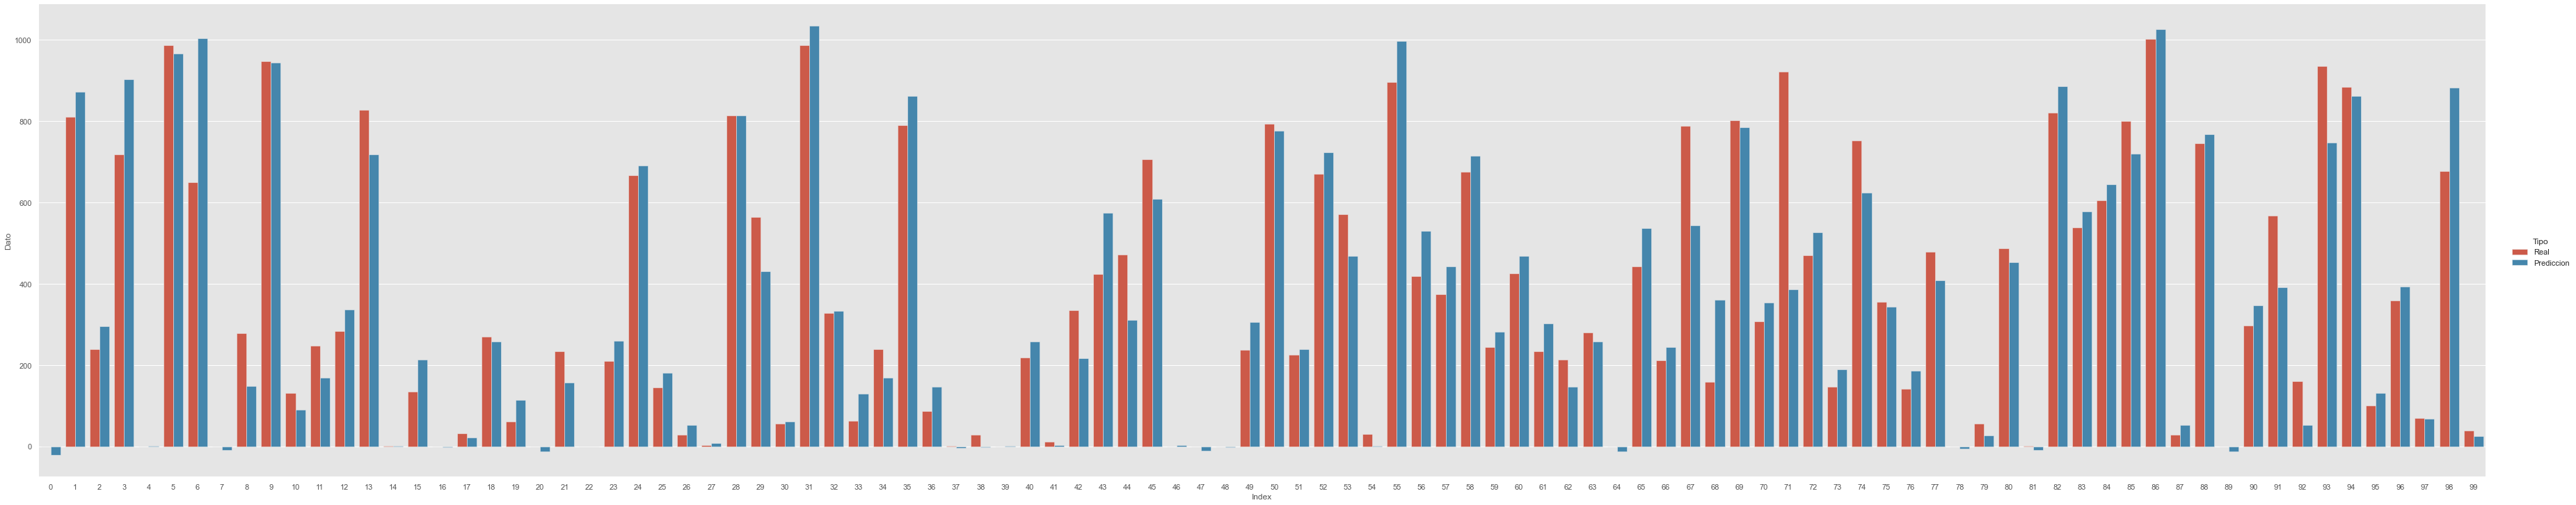

In [134]:
graf_compara('TensorFlow Model', list(y_test[columnas_objetivo[0]])[:100], pred_tensor[:100])

Prediction values and overall trend of target values are visually compared

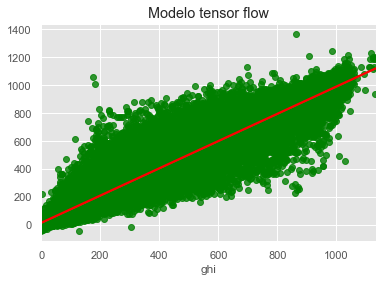

In [135]:
sns.regplot(x = y_test, y = pred_tensor,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('TensorFlow Model');

The metrics are obtained from the model results

In [136]:
metricas_pred_tensor = metricas('TensorFlow Model', y_test, pred_tensor)

MODEL:  Modelo de tensor flow
MAE:  53.16871201236474
MSE:  85.60533407715572
RMSE:  85.60533407715572
R2 :  0.9289717835249144


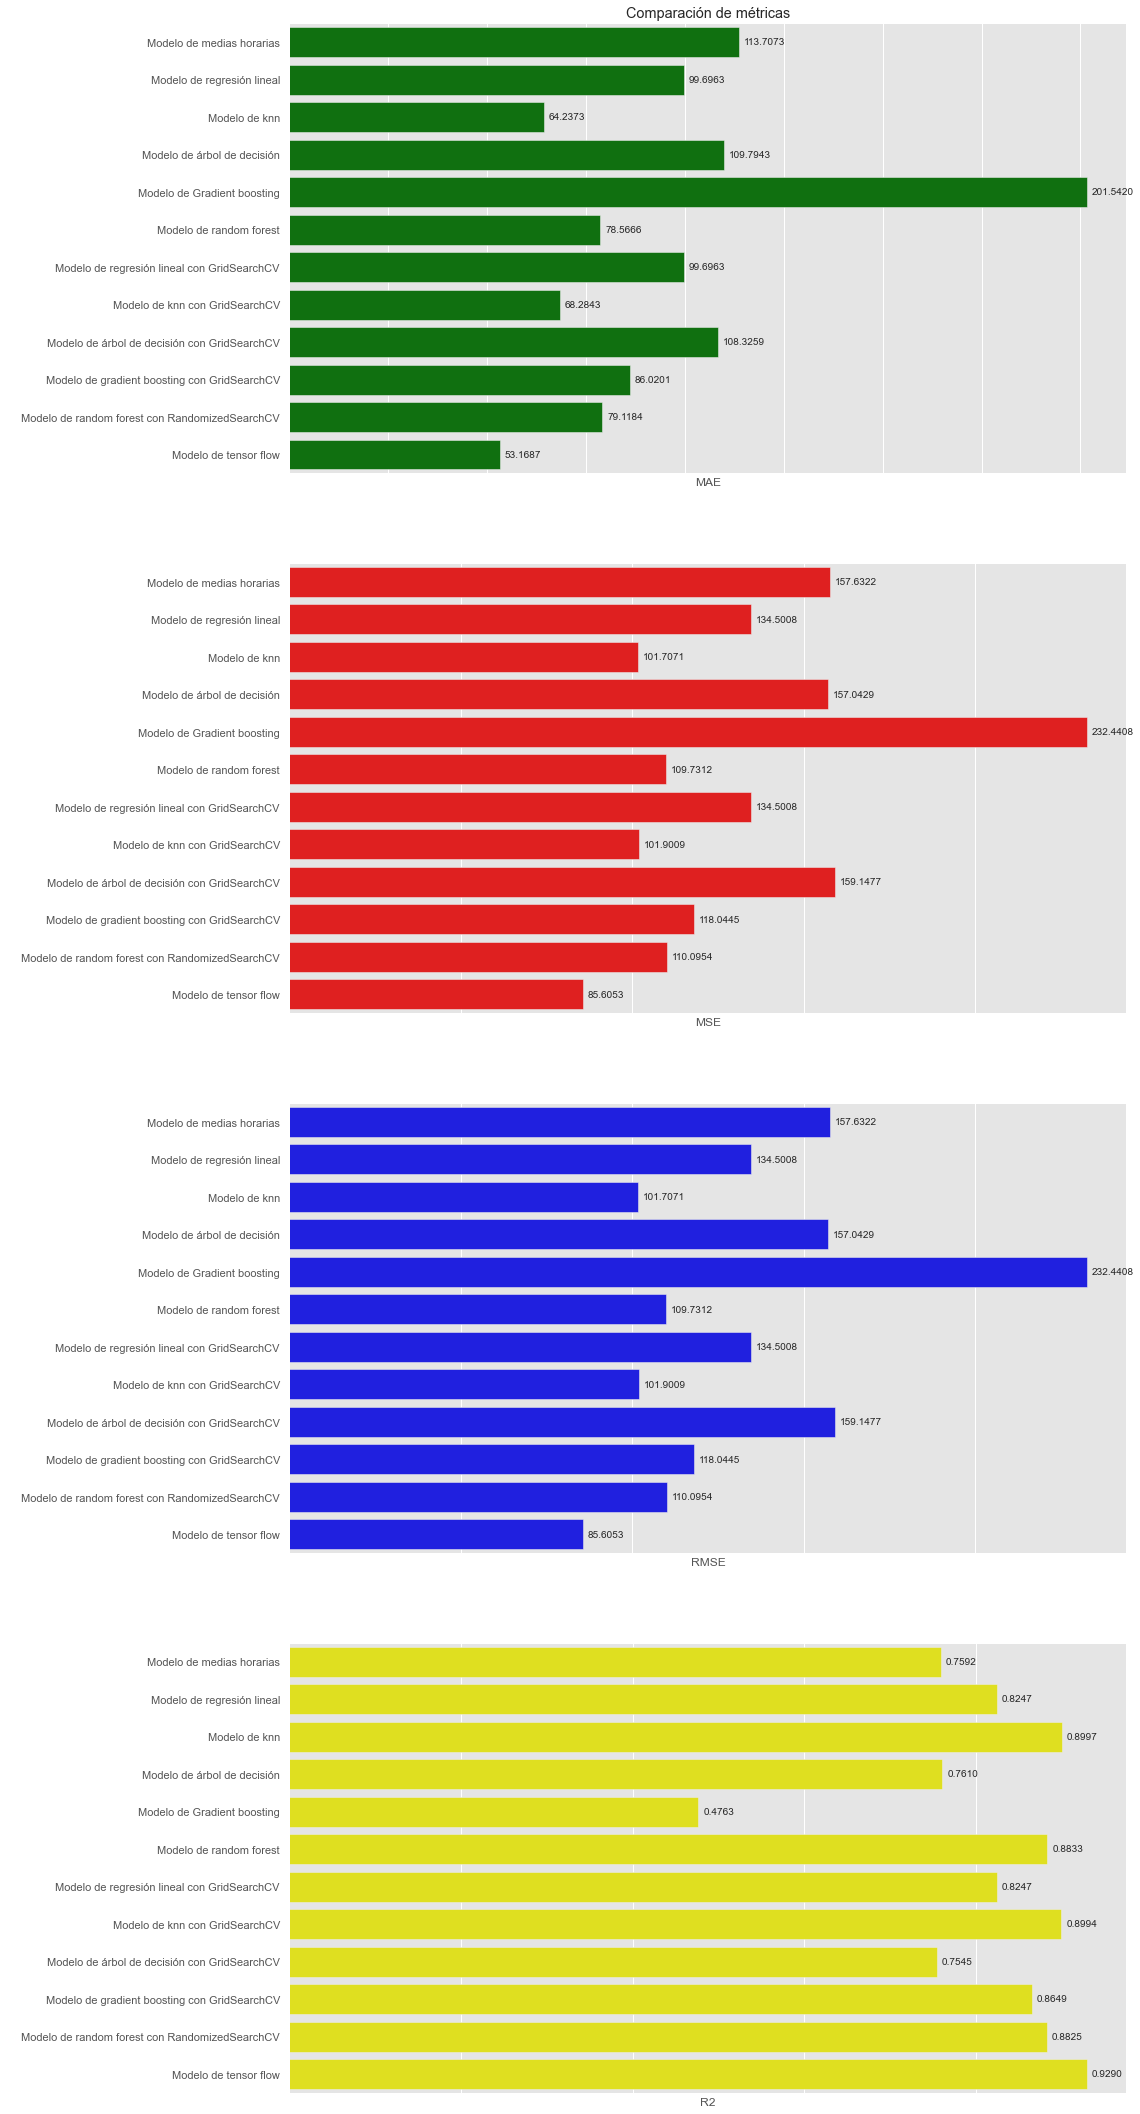

In [137]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid,
                    metricas_gbm_grid,
                    metricas_forest_random,
                    metricas_pred_tensor])

# Model selection
<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

A comparison of the results of the different models is shown

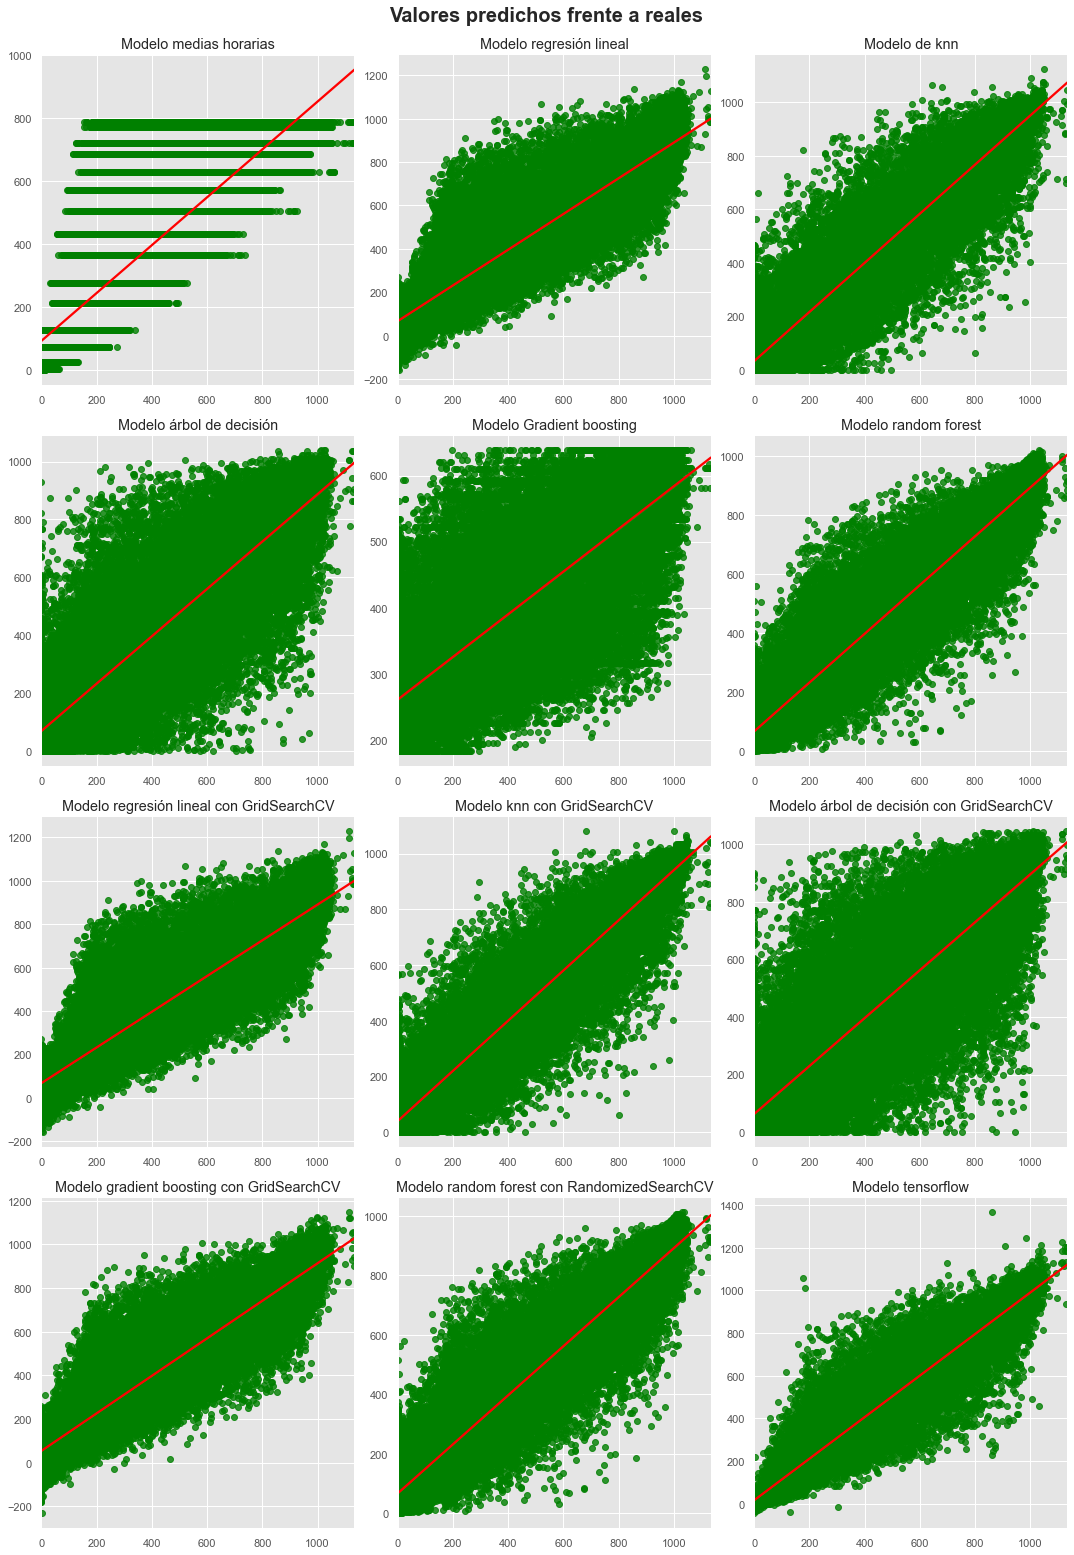

In [140]:
fig, ax = plt.subplots(4,3, figsize = (15,22))
fig.suptitle('Predicted vs. Actual Values', fontsize = 20, fontweight = 'bold')
fig.tight_layout()
fig.subplots_adjust(top = 0.95, hspace = 0.15)

sns.regplot(x = y_test, y = pred_media, ax = ax[0,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Hourly averages model');
sns.regplot(x = y_test, y = pred_reg_lineal, ax = ax[0,1],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Linear regression model');
sns.regplot(x = y_test, y = pred_knn, ax = ax[0,2],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Knn model');
sns.regplot(x = y_test, y = pred_tree, ax = ax[1,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Decision tree model');
sns.regplot(x = y_test, y = pred_gbm, ax = ax[1,1],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Gradient boosting model');
sns.regplot(x = y_test, y = pred_forest, ax = ax[1,2],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Random forest model');
sns.regplot(x = y_test, y = pred_reg_grid, ax = ax[2,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Linear Regression Model with GridSearchCV');
sns.regplot(x = y_test, y = pred_knn_grid,  ax = ax[2,1],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Knn model with GridSearchCV');
sns.regplot(x = y_test, y = pred_tree_grid, ax = ax[2,2],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Decision tree model with GridSearchCV');
sns.regplot(x = y_test, y = pred_gbm_grid, ax = ax[3,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Gradient boosting model with GridSearchCV');
sns.regplot(x = y_test, y = pred_forest_random, ax = ax[3,1], 
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Random forest model with RandomizedSearchCV');
sns.regplot(x = y_test, y = pred_tensor, ax = ax[3,2], 
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Tensorflow model');

for fila in ax:
    for columna in fila:
        columna.set_xlabel("")
        columna.set_ylabel("")

The mean value of solar radiation in the horizontal plane per hour (W/m²) is:

In [64]:
# The mean of the objective variable is obtained

df[columnas_objetivo].mean()

ghi    403.843436
dtype: float64

The mae of the k-Nearest Neighbors method with GridSearchCV over the mean value is:

In [65]:
metricas_knn[1]/df[columnas_objetivo].mean()[0]*100

17.482295683601823

The selected model is that of k-Nearest Neighbors, which has a higher r² (90%) than the rest of the models and a lower mean error (16% on the mean value). Although TensorFlow has a somewhat better metric, this model will be easier to store and use

### Adjusted R²

Adjusted R-squared is a modified version of R-squared that fits the number of predictors in a regression model. The metric r² never decreases with the introduction of new predictor variables. Therefore, the adjusted r² of this is also checked, whose value depends on the number of explanatory variables.

In [66]:
r2_adjusted = 1-((len(y_train)-1)/(len(y_train)-1-x_train.shape[1]))*(1-metricas_knn[4])
r2_adjusted

0.8973921157518174

It is verified that it returns a similar value, so the number of predictor variables does not interfere with the metrics

# Check for overfitting

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

The model is tested with other groups of random data, to check if the results are similar

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

resultados = []

for i in range(1,5):
    
    # The data is obtained
    df_fin = df_datos.sample(frac = 0.6, random_state = i)
    
    # The data is divided into target and input columns and divided into train and test
    x_fin = df_fin[columnas_utiles]
    y_fin = df_fin[columnas_objetivo]
    x_train_fin, x_test_fin, y_train_fin, y_test_fin = dividir_train_test(x_fin,y_fin, 0.8)
    
    # Standardization
    scaler = StandardScaler()
    columnas = x_train_fin.columns
    x_train_fin_normal = scaler.fit_transform(x_train_fin[columnas])
    x_train_fin_normal = pd.DataFrame(x_train_fin_normal, columns = columnas)
    
    columnas = x_test_fin.columns
    x_test_fin_normal = scaler.transform(x_test_fin[columnas])
    x_test_fin_normal = pd.DataFrame(x_test_fin_normal, columns = columnas)
    
    # PCA
    pca = PCA(n_components = 62)
    principalComponents = pca.fit_transform(x_train_fin_normal)
    x_train_fin_pca = pd.DataFrame(data = principalComponents)
    
    principalComponents = pca.transform(x_test_fin_normal)
    x_test_fin_pca = pd.DataFrame(data = principalComponents)
    
    # The model is created and trained
    knn_fin = KNeighborsRegressor(n_neighbors = 4, leaf_size = 10, weights = 'uniform')

    knn_fin.fit(x_train_fin,y_train_fin.values.ravel())
    
    # The prediction is obtained
    pred_knn_fin_ = knn_fin.predict(x_test_fin)
    pred_knn_fin = []
    [pred_knn_fin.append(y) for y in pred_knn_fin_.tolist()]
    
    # The metrics of the model are obtained
    metricas_final = metricas('Knn model', y_test_fin, pred_knn_fin)
    
    
    # The results are saved
    resultados.append(metricas_final[4])

print("The mean value of R² is {}, with a standard deviation of {}".format(np.mean(resultados), np.std(resultados)))

x_train: 79.99960335036724%. Nº of data: 121013
y_train: 79.99960335036724%. Nº of data: 121013
x_test: 20.00039664963277%. Nº of data: 30254
y_test: 20.00039664963277%. Nº of data: 30254
MODEL:  Knn model
MAE:  87.89079449246381
MSE:  136.32864299903414
RMSE:  136.32864299903414
R2 :  0.827342219532776
x_train: 79.99960335036724%. Nº of data: 121013
y_train: 79.99960335036724%. Nº of data: 121013
x_test: 20.00039664963277%. Nº of data: 30254
y_test: 20.00039664963277%. Nº of data: 30254
MODEL:  Knn model
MAE:  88.59962975143783
MSE:  136.91864273186704
RMSE:  136.91864273186704
R2 :  0.8237572869317353
x_train: 79.99960335036724%. Nº of data: 121013
y_train: 79.99960335036724%. Nº of data: 121013
x_test: 20.00039664963277%. Nº of data: 30254
y_test: 20.00039664963277%. Nº of data: 30254
MODEL:  Knn model
MAE:  86.87780308471608
MSE:  135.48781660879476
RMSE:  135.48781660879476
R2 :  0.8276749136024679
x_train: 79.99960335036724%. Nº of data: 121013
y_train: 79.99960335036724%. Nº of 

It is concluded that the model is valid

# The model is saved

<div style = "float:right"><a style="text-decoration:none" href = "#Prediction-model:-Solar-radiation">

In [68]:
modelo = "modelo_rad.pkl"

with open(directorio + 'data/Modelo/' + modelo, 'wb') as file:
        pk.dump(knn, file)    